In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b50_k7_b50_k9_b50_k11_b50_k13_b50_k15_b50_k17_b50_k19_b50_k21_b50_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:50 - loss: 2.3569 - STD: 0.0812 - MAE: 0.2205

  5/395 [..............................] - ETA: 6s - loss: 2.1428 - STD: 0.0545 - MAE: 0.2174  

  9/395 [..............................] - ETA: 6s - loss: 2.1200 - STD: 0.0525 - MAE: 0.2169

 13/395 [..............................] - ETA: 5s - loss: 2.1036 - STD: 0.0498 - MAE: 0.2167

 17/395 [>.............................] - ETA: 5s - loss: 2.0916 - STD: 0.0457 - MAE: 0.2167

 21/395 [>.............................] - ETA: 5s - loss: 2.0846 - STD: 0.0426 - MAE: 0.2167

 25/395 [>.............................] - ETA: 5s - loss: 2.0788 - STD: 0.0411 - MAE: 0.2167

 29/395 [=>............................] - ETA: 5s - loss: 2.0732 - STD: 0.0401 - MAE: 0.2166

 33/395 [=>............................] - ETA: 5s - loss: 2.0677 - STD: 0.0393 - MAE: 0.2165

 37/395 [=>............................] - ETA: 5s - loss: 2.0609 - STD: 0.0391 - MAE: 0.2163

 40/395 [==>...........................] - ETA: 5s - loss: 2.0549 - STD: 0.0393 - MAE: 0.2161

 44/395 [==>...........................] - ETA: 5s - loss: 2.0454 - STD: 0.0401 - MAE: 0.2157

 48/395 [==>...........................] - ETA: 5s - loss: 2.0348 - STD: 0.0418 - MAE: 0.2152

 52/395 [==>...........................] - ETA: 5s - loss: 2.0229 - STD: 0.0436 - MAE: 0.2146

 56/395 [===>..........................] - ETA: 5s - loss: 2.0096 - STD: 0.0456 - MAE: 0.2140

 60/395 [===>..........................] - ETA: 5s - loss: 1.9948 - STD: 0.0476 - MAE: 0.2133

 64/395 [===>..........................] - ETA: 5s - loss: 1.9788 - STD: 0.0498 - MAE: 0.2125

 67/395 [====>.........................] - ETA: 5s - loss: 1.9658 - STD: 0.0515 - MAE: 0.2119

 71/395 [====>.........................] - ETA: 5s - loss: 1.9478 - STD: 0.0540 - MAE: 0.2109

 75/395 [====>.........................] - ETA: 4s - loss: 1.9285 - STD: 0.0567 - MAE: 0.2099

 79/395 [=====>........................] - ETA: 4s - loss: 1.9094 - STD: 0.0597 - MAE: 0.2087

 83/395 [=====>........................] - ETA: 4s - loss: 1.8908 - STD: 0.0627 - MAE: 0.2076

 86/395 [=====>........................] - ETA: 4s - loss: 1.8773 - STD: 0.0649 - MAE: 0.2067

 90/395 [=====>........................] - ETA: 4s - loss: 1.8600 - STD: 0.0679 - MAE: 0.2056

 94/395 [======>.......................] - ETA: 4s - loss: 1.8433 - STD: 0.0706 - MAE: 0.2045

 98/395 [======>.......................] - ETA: 4s - loss: 1.8275 - STD: 0.0732 - MAE: 0.2035

102/395 [======>.......................] - ETA: 4s - loss: 1.8125 - STD: 0.0757 - MAE: 0.2025

106/395 [=======>......................] - ETA: 4s - loss: 1.7980 - STD: 0.0780 - MAE: 0.2015

110/395 [=======>......................] - ETA: 4s - loss: 1.7840 - STD: 0.0803 - MAE: 0.2006

114/395 [=======>......................] - ETA: 4s - loss: 1.7706 - STD: 0.0825 - MAE: 0.1996

118/395 [=======>......................] - ETA: 4s - loss: 1.7578 - STD: 0.0846 - MAE: 0.1987

122/395 [========>.....................] - ETA: 4s - loss: 1.7456 - STD: 0.0866 - MAE: 0.1979

126/395 [========>.....................] - ETA: 4s - loss: 1.7337 - STD: 0.0886 - MAE: 0.1970

130/395 [========>.....................] - ETA: 4s - loss: 1.7222 - STD: 0.0905 - MAE: 0.1962

134/395 [=========>....................] - ETA: 4s - loss: 1.7112 - STD: 0.0923 - MAE: 0.1954

138/395 [=========>....................] - ETA: 4s - loss: 1.7004 - STD: 0.0941 - MAE: 0.1946

142/395 [=========>....................] - ETA: 3s - loss: 1.6900 - STD: 0.0959 - MAE: 0.1938

146/395 [==========>...................] - ETA: 3s - loss: 1.6800 - STD: 0.0975 - MAE: 0.1931

150/395 [==========>...................] - ETA: 3s - loss: 1.6704 - STD: 0.0992 - MAE: 0.1923

154/395 [==========>...................] - ETA: 3s - loss: 1.6613 - STD: 0.1007 - MAE: 0.1916

158/395 [===========>..................] - ETA: 3s - loss: 1.6524 - STD: 0.1022 - MAE: 0.1909

162/395 [===========>..................] - ETA: 3s - loss: 1.6437 - STD: 0.1037 - MAE: 0.1902

166/395 [===========>..................] - ETA: 3s - loss: 1.6353 - STD: 0.1052 - MAE: 0.1896

170/395 [===========>..................] - ETA: 3s - loss: 1.6271 - STD: 0.1066 - MAE: 0.1889

174/395 [============>.................] - ETA: 3s - loss: 1.6190 - STD: 0.1079 - MAE: 0.1882

177/395 [============>.................] - ETA: 3s - loss: 1.6133 - STD: 0.1089 - MAE: 0.1878

181/395 [============>.................] - ETA: 3s - loss: 1.6056 - STD: 0.1102 - MAE: 0.1872

185/395 [=============>................] - ETA: 3s - loss: 1.5981 - STD: 0.1115 - MAE: 0.1865

189/395 [=============>................] - ETA: 3s - loss: 1.5908 - STD: 0.1127 - MAE: 0.1859

193/395 [=============>................] - ETA: 3s - loss: 1.5837 - STD: 0.1140 - MAE: 0.1854

197/395 [=============>................] - ETA: 3s - loss: 1.5770 - STD: 0.1151 - MAE: 0.1848

201/395 [==============>...............] - ETA: 3s - loss: 1.5703 - STD: 0.1163 - MAE: 0.1842

205/395 [==============>...............] - ETA: 2s - loss: 1.5639 - STD: 0.1174 - MAE: 0.1837

209/395 [==============>...............] - ETA: 2s - loss: 1.5576 - STD: 0.1185 - MAE: 0.1832

213/395 [===============>..............] - ETA: 2s - loss: 1.5515 - STD: 0.1195 - MAE: 0.1826

217/395 [===============>..............] - ETA: 2s - loss: 1.5455 - STD: 0.1206 - MAE: 0.1821

221/395 [===============>..............] - ETA: 2s - loss: 1.5398 - STD: 0.1216 - MAE: 0.1816

225/395 [================>.............] - ETA: 2s - loss: 1.5344 - STD: 0.1225 - MAE: 0.1812

229/395 [================>.............] - ETA: 2s - loss: 1.5291 - STD: 0.1235 - MAE: 0.1807

233/395 [================>.............] - ETA: 2s - loss: 1.5240 - STD: 0.1244 - MAE: 0.1803

237/395 [=================>............] - ETA: 2s - loss: 1.5188 - STD: 0.1253 - MAE: 0.1798

241/395 [=================>............] - ETA: 2s - loss: 1.5138 - STD: 0.1262 - MAE: 0.1794

245/395 [=================>............] - ETA: 2s - loss: 1.5090 - STD: 0.1270 - MAE: 0.1790

249/395 [=================>............] - ETA: 2s - loss: 1.5043 - STD: 0.1279 - MAE: 0.1786

253/395 [==================>...........] - ETA: 2s - loss: 1.4998 - STD: 0.1287 - MAE: 0.1782

257/395 [==================>...........] - ETA: 2s - loss: 1.4952 - STD: 0.1295 - MAE: 0.1778

261/395 [==================>...........] - ETA: 2s - loss: 1.4907 - STD: 0.1302 - MAE: 0.1774

265/395 [===================>..........] - ETA: 2s - loss: 1.4863 - STD: 0.1310 - MAE: 0.1770

269/395 [===================>..........] - ETA: 1s - loss: 1.4820 - STD: 0.1317 - MAE: 0.1766

273/395 [===================>..........] - ETA: 1s - loss: 1.4778 - STD: 0.1324 - MAE: 0.1763

277/395 [====================>.........] - ETA: 1s - loss: 1.4735 - STD: 0.1331 - MAE: 0.1759

281/395 [====================>.........] - ETA: 1s - loss: 1.4694 - STD: 0.1338 - MAE: 0.1755

285/395 [====================>.........] - ETA: 1s - loss: 1.4654 - STD: 0.1345 - MAE: 0.1752

289/395 [====================>.........] - ETA: 1s - loss: 1.4613 - STD: 0.1352 - MAE: 0.1748

292/395 [=====================>........] - ETA: 1s - loss: 1.4585 - STD: 0.1357 - MAE: 0.1746

296/395 [=====================>........] - ETA: 1s - loss: 1.4546 - STD: 0.1363 - MAE: 0.1742

300/395 [=====================>........] - ETA: 1s - loss: 1.4508 - STD: 0.1369 - MAE: 0.1739

304/395 [======================>.......] - ETA: 1s - loss: 1.4472 - STD: 0.1375 - MAE: 0.1736

308/395 [======================>.......] - ETA: 1s - loss: 1.4436 - STD: 0.1382 - MAE: 0.1733

312/395 [======================>.......] - ETA: 1s - loss: 1.4403 - STD: 0.1388 - MAE: 0.1730

315/395 [======================>.......] - ETA: 1s - loss: 1.4378 - STD: 0.1392 - MAE: 0.1727

319/395 [=======================>......] - ETA: 1s - loss: 1.4346 - STD: 0.1398 - MAE: 0.1725

323/395 [=======================>......] - ETA: 1s - loss: 1.4313 - STD: 0.1403 - MAE: 0.1722

327/395 [=======================>......] - ETA: 1s - loss: 1.4280 - STD: 0.1409 - MAE: 0.1719

331/395 [========================>.....] - ETA: 0s - loss: 1.4248 - STD: 0.1414 - MAE: 0.1716

335/395 [========================>.....] - ETA: 0s - loss: 1.4216 - STD: 0.1420 - MAE: 0.1713

339/395 [========================>.....] - ETA: 0s - loss: 1.4184 - STD: 0.1425 - MAE: 0.1710

343/395 [=========================>....] - ETA: 0s - loss: 1.4154 - STD: 0.1430 - MAE: 0.1707

347/395 [=========================>....] - ETA: 0s - loss: 1.4122 - STD: 0.1435 - MAE: 0.1705

351/395 [=========================>....] - ETA: 0s - loss: 1.4092 - STD: 0.1440 - MAE: 0.1702

355/395 [=========================>....] - ETA: 0s - loss: 1.4062 - STD: 0.1445 - MAE: 0.1699

358/395 [==========================>...] - ETA: 0s - loss: 1.4040 - STD: 0.1449 - MAE: 0.1697

361/395 [==========================>...] - ETA: 0s - loss: 1.4019 - STD: 0.1452 - MAE: 0.1695

365/395 [==========================>...] - ETA: 0s - loss: 1.3990 - STD: 0.1457 - MAE: 0.1693

369/395 [===========================>..] - ETA: 0s - loss: 1.3963 - STD: 0.1462 - MAE: 0.1690

373/395 [===========================>..] - ETA: 0s - loss: 1.3934 - STD: 0.1467 - MAE: 0.1688

377/395 [===========================>..] - ETA: 0s - loss: 1.3909 - STD: 0.1471 - MAE: 0.1685

378/395 [===========================>..] - ETA: 0s - loss: 1.3906 - STD: 0.1472 - MAE: 0.1685

382/395 [============================>.] - ETA: 0s - loss: 1.3879 - STD: 0.1477 - MAE: 0.1682

386/395 [============================>.] - ETA: 0s - loss: 1.3853 - STD: 0.1481 - MAE: 0.1680

390/395 [============================>.] - ETA: 0s - loss: 1.3827 - STD: 0.1485 - MAE: 0.1678

394/395 [============================>.] - ETA: 0s - loss: 1.3801 - STD: 0.1490 - MAE: 0.1675

395/395 [==============================] - 9s 20ms/step - loss: 1.3794 - STD: 0.1491 - MAE: 0.1675 - val_loss: 1.1464 - val_STD: 0.1941 - val_MAE: 0.1421


Epoch 2/10000


  1/395 [..............................] - ETA: 18s - loss: 1.1268 - STD: 0.1894 - MAE: 0.1449

  4/395 [..............................] - ETA: 6s - loss: 1.1210 - STD: 0.1905 - MAE: 0.1444 

  8/395 [..............................] - ETA: 6s - loss: 1.1256 - STD: 0.1910 - MAE: 0.1444

 12/395 [..............................] - ETA: 6s - loss: 1.1278 - STD: 0.1911 - MAE: 0.1445

 16/395 [>.............................] - ETA: 5s - loss: 1.1316 - STD: 0.1911 - MAE: 0.1447

 20/395 [>.............................] - ETA: 5s - loss: 1.1389 - STD: 0.1909 - MAE: 0.1452

 24/395 [>.............................] - ETA: 5s - loss: 1.1380 - STD: 0.1910 - MAE: 0.1451

 28/395 [=>............................] - ETA: 5s - loss: 1.1388 - STD: 0.1910 - MAE: 0.1452

 32/395 [=>............................] - ETA: 5s - loss: 1.1375 - STD: 0.1910 - MAE: 0.1451

 36/395 [=>............................] - ETA: 5s - loss: 1.1349 - STD: 0.1912 - MAE: 0.1449

 40/395 [==>...........................] - ETA: 5s - loss: 1.1338 - STD: 0.1912 - MAE: 0.1448

 44/395 [==>...........................] - ETA: 5s - loss: 1.1318 - STD: 0.1912 - MAE: 0.1447

 48/395 [==>...........................] - ETA: 5s - loss: 1.1296 - STD: 0.1913 - MAE: 0.1446

 52/395 [==>...........................] - ETA: 5s - loss: 1.1281 - STD: 0.1914 - MAE: 0.1445

 56/395 [===>..........................] - ETA: 5s - loss: 1.1269 - STD: 0.1915 - MAE: 0.1443

 60/395 [===>..........................] - ETA: 5s - loss: 1.1254 - STD: 0.1917 - MAE: 0.1442

 64/395 [===>..........................] - ETA: 5s - loss: 1.1237 - STD: 0.1918 - MAE: 0.1441

 68/395 [====>.........................] - ETA: 5s - loss: 1.1227 - STD: 0.1920 - MAE: 0.1439

 72/395 [====>.........................] - ETA: 5s - loss: 1.1220 - STD: 0.1921 - MAE: 0.1439

 76/395 [====>.........................] - ETA: 4s - loss: 1.1211 - STD: 0.1921 - MAE: 0.1438

 80/395 [=====>........................] - ETA: 4s - loss: 1.1209 - STD: 0.1922 - MAE: 0.1438

 83/395 [=====>........................] - ETA: 4s - loss: 1.1200 - STD: 0.1923 - MAE: 0.1437

 87/395 [=====>........................] - ETA: 4s - loss: 1.1193 - STD: 0.1924 - MAE: 0.1436

 91/395 [=====>........................] - ETA: 4s - loss: 1.1197 - STD: 0.1926 - MAE: 0.1436

 95/395 [======>.......................] - ETA: 4s - loss: 1.1199 - STD: 0.1927 - MAE: 0.1435

 99/395 [======>.......................] - ETA: 4s - loss: 1.1193 - STD: 0.1927 - MAE: 0.1435

103/395 [======>.......................] - ETA: 4s - loss: 1.1185 - STD: 0.1928 - MAE: 0.1434

107/395 [=======>......................] - ETA: 4s - loss: 1.1176 - STD: 0.1928 - MAE: 0.1434

111/395 [=======>......................] - ETA: 4s - loss: 1.1171 - STD: 0.1929 - MAE: 0.1433

114/395 [=======>......................] - ETA: 4s - loss: 1.1163 - STD: 0.1929 - MAE: 0.1433

118/395 [=======>......................] - ETA: 4s - loss: 1.1151 - STD: 0.1930 - MAE: 0.1432

122/395 [========>.....................] - ETA: 4s - loss: 1.1142 - STD: 0.1930 - MAE: 0.1431

126/395 [========>.....................] - ETA: 4s - loss: 1.1131 - STD: 0.1931 - MAE: 0.1430

130/395 [========>.....................] - ETA: 4s - loss: 1.1122 - STD: 0.1932 - MAE: 0.1430

134/395 [=========>....................] - ETA: 4s - loss: 1.1112 - STD: 0.1933 - MAE: 0.1429

137/395 [=========>....................] - ETA: 4s - loss: 1.1107 - STD: 0.1933 - MAE: 0.1428

141/395 [=========>....................] - ETA: 3s - loss: 1.1102 - STD: 0.1934 - MAE: 0.1428

145/395 [==========>...................] - ETA: 3s - loss: 1.1097 - STD: 0.1935 - MAE: 0.1427

149/395 [==========>...................] - ETA: 3s - loss: 1.1094 - STD: 0.1936 - MAE: 0.1427

153/395 [==========>...................] - ETA: 3s - loss: 1.1087 - STD: 0.1937 - MAE: 0.1426

157/395 [==========>...................] - ETA: 3s - loss: 1.1084 - STD: 0.1938 - MAE: 0.1426

161/395 [===========>..................] - ETA: 3s - loss: 1.1079 - STD: 0.1938 - MAE: 0.1425

165/395 [===========>..................] - ETA: 3s - loss: 1.1079 - STD: 0.1939 - MAE: 0.1425

169/395 [===========>..................] - ETA: 3s - loss: 1.1074 - STD: 0.1940 - MAE: 0.1424

173/395 [============>.................] - ETA: 3s - loss: 1.1066 - STD: 0.1941 - MAE: 0.1423

177/395 [============>.................] - ETA: 3s - loss: 1.1061 - STD: 0.1941 - MAE: 0.1423

181/395 [============>.................] - ETA: 3s - loss: 1.1055 - STD: 0.1942 - MAE: 0.1422

185/395 [=============>................] - ETA: 3s - loss: 1.1047 - STD: 0.1943 - MAE: 0.1422

189/395 [=============>................] - ETA: 3s - loss: 1.1038 - STD: 0.1943 - MAE: 0.1421

193/395 [=============>................] - ETA: 3s - loss: 1.1029 - STD: 0.1944 - MAE: 0.1420

197/395 [=============>................] - ETA: 3s - loss: 1.1021 - STD: 0.1945 - MAE: 0.1419

201/395 [==============>...............] - ETA: 3s - loss: 1.1014 - STD: 0.1946 - MAE: 0.1419

205/395 [==============>...............] - ETA: 2s - loss: 1.1006 - STD: 0.1947 - MAE: 0.1418

209/395 [==============>...............] - ETA: 2s - loss: 1.1002 - STD: 0.1947 - MAE: 0.1417

213/395 [===============>..............] - ETA: 2s - loss: 1.1002 - STD: 0.1948 - MAE: 0.1417

217/395 [===============>..............] - ETA: 2s - loss: 1.0997 - STD: 0.1949 - MAE: 0.1417

221/395 [===============>..............] - ETA: 2s - loss: 1.0993 - STD: 0.1950 - MAE: 0.1416

224/395 [================>.............] - ETA: 2s - loss: 1.0987 - STD: 0.1950 - MAE: 0.1415

228/395 [================>.............] - ETA: 2s - loss: 1.0982 - STD: 0.1951 - MAE: 0.1415

232/395 [================>.............] - ETA: 2s - loss: 1.0976 - STD: 0.1952 - MAE: 0.1414

236/395 [================>.............] - ETA: 2s - loss: 1.0968 - STD: 0.1952 - MAE: 0.1414

240/395 [=================>............] - ETA: 2s - loss: 1.0962 - STD: 0.1953 - MAE: 0.1413

244/395 [=================>............] - ETA: 2s - loss: 1.0955 - STD: 0.1954 - MAE: 0.1412

247/395 [=================>............] - ETA: 2s - loss: 1.0948 - STD: 0.1954 - MAE: 0.1412

251/395 [==================>...........] - ETA: 2s - loss: 1.0940 - STD: 0.1955 - MAE: 0.1411

255/395 [==================>...........] - ETA: 2s - loss: 1.0933 - STD: 0.1956 - MAE: 0.1410

259/395 [==================>...........] - ETA: 2s - loss: 1.0925 - STD: 0.1957 - MAE: 0.1410

263/395 [==================>...........] - ETA: 2s - loss: 1.0919 - STD: 0.1957 - MAE: 0.1409

266/395 [===================>..........] - ETA: 2s - loss: 1.0914 - STD: 0.1958 - MAE: 0.1409

270/395 [===================>..........] - ETA: 1s - loss: 1.0909 - STD: 0.1959 - MAE: 0.1408

274/395 [===================>..........] - ETA: 1s - loss: 1.0903 - STD: 0.1960 - MAE: 0.1407

278/395 [====================>.........] - ETA: 1s - loss: 1.0898 - STD: 0.1960 - MAE: 0.1407

282/395 [====================>.........] - ETA: 1s - loss: 1.0891 - STD: 0.1961 - MAE: 0.1406

286/395 [====================>.........] - ETA: 1s - loss: 1.0885 - STD: 0.1962 - MAE: 0.1406

290/395 [=====================>........] - ETA: 1s - loss: 1.0878 - STD: 0.1962 - MAE: 0.1405

294/395 [=====================>........] - ETA: 1s - loss: 1.0872 - STD: 0.1963 - MAE: 0.1404

298/395 [=====================>........] - ETA: 1s - loss: 1.0867 - STD: 0.1964 - MAE: 0.1404

302/395 [=====================>........] - ETA: 1s - loss: 1.0860 - STD: 0.1965 - MAE: 0.1403

306/395 [======================>.......] - ETA: 1s - loss: 1.0852 - STD: 0.1965 - MAE: 0.1402

310/395 [======================>.......] - ETA: 1s - loss: 1.0845 - STD: 0.1966 - MAE: 0.1402

314/395 [======================>.......] - ETA: 1s - loss: 1.0839 - STD: 0.1967 - MAE: 0.1401

318/395 [=======================>......] - ETA: 1s - loss: 1.0831 - STD: 0.1968 - MAE: 0.1400

322/395 [=======================>......] - ETA: 1s - loss: 1.0826 - STD: 0.1968 - MAE: 0.1400

326/395 [=======================>......] - ETA: 1s - loss: 1.0822 - STD: 0.1969 - MAE: 0.1399

330/395 [========================>.....] - ETA: 1s - loss: 1.0819 - STD: 0.1970 - MAE: 0.1399

334/395 [========================>.....] - ETA: 0s - loss: 1.0816 - STD: 0.1971 - MAE: 0.1398

338/395 [========================>.....] - ETA: 0s - loss: 1.0812 - STD: 0.1971 - MAE: 0.1398

342/395 [========================>.....] - ETA: 0s - loss: 1.0806 - STD: 0.1972 - MAE: 0.1397

346/395 [=========================>....] - ETA: 0s - loss: 1.0799 - STD: 0.1972 - MAE: 0.1397

350/395 [=========================>....] - ETA: 0s - loss: 1.0794 - STD: 0.1973 - MAE: 0.1396

354/395 [=========================>....] - ETA: 0s - loss: 1.0791 - STD: 0.1974 - MAE: 0.1396

358/395 [==========================>...] - ETA: 0s - loss: 1.0788 - STD: 0.1975 - MAE: 0.1395

362/395 [==========================>...] - ETA: 0s - loss: 1.0781 - STD: 0.1975 - MAE: 0.1395

366/395 [==========================>...] - ETA: 0s - loss: 1.0776 - STD: 0.1976 - MAE: 0.1394

370/395 [===========================>..] - ETA: 0s - loss: 1.0769 - STD: 0.1977 - MAE: 0.1393

374/395 [===========================>..] - ETA: 0s - loss: 1.0763 - STD: 0.1977 - MAE: 0.1393

378/395 [===========================>..] - ETA: 0s - loss: 1.0757 - STD: 0.1978 - MAE: 0.1392

382/395 [============================>.] - ETA: 0s - loss: 1.0752 - STD: 0.1979 - MAE: 0.1392

386/395 [============================>.] - ETA: 0s - loss: 1.0746 - STD: 0.1979 - MAE: 0.1391

390/395 [============================>.] - ETA: 0s - loss: 1.0743 - STD: 0.1980 - MAE: 0.1391

394/395 [============================>.] - ETA: 0s - loss: 1.0738 - STD: 0.1981 - MAE: 0.1390

395/395 [==============================] - 7s 17ms/step - loss: 1.0737 - STD: 0.1981 - MAE: 0.1390 - val_loss: 1.0758 - val_STD: 0.2077 - val_MAE: 0.1338


Epoch 3/10000


  1/395 [..............................] - ETA: 18s - loss: 1.0306 - STD: 0.2062 - MAE: 0.1334

  4/395 [..............................] - ETA: 7s - loss: 1.0282 - STD: 0.2055 - MAE: 0.1336 

  8/395 [..............................] - ETA: 6s - loss: 1.0210 - STD: 0.2048 - MAE: 0.1335

 12/395 [..............................] - ETA: 6s - loss: 1.0190 - STD: 0.2046 - MAE: 0.1334

 16/395 [>.............................] - ETA: 6s - loss: 1.0179 - STD: 0.2046 - MAE: 0.1334

 20/395 [>.............................] - ETA: 6s - loss: 1.0159 - STD: 0.2048 - MAE: 0.1332

 24/395 [>.............................] - ETA: 5s - loss: 1.0153 - STD: 0.2049 - MAE: 0.1331

 28/395 [=>............................] - ETA: 5s - loss: 1.0169 - STD: 0.2049 - MAE: 0.1332

 32/395 [=>............................] - ETA: 5s - loss: 1.0175 - STD: 0.2050 - MAE: 0.1332

 36/395 [=>............................] - ETA: 5s - loss: 1.0172 - STD: 0.2052 - MAE: 0.1331

 40/395 [==>...........................] - ETA: 5s - loss: 1.0177 - STD: 0.2053 - MAE: 0.1331

 44/395 [==>...........................] - ETA: 5s - loss: 1.0187 - STD: 0.2053 - MAE: 0.1331

 48/395 [==>...........................] - ETA: 5s - loss: 1.0196 - STD: 0.2053 - MAE: 0.1332

 52/395 [==>...........................] - ETA: 5s - loss: 1.0183 - STD: 0.2054 - MAE: 0.1331

 56/395 [===>..........................] - ETA: 5s - loss: 1.0180 - STD: 0.2054 - MAE: 0.1331

 60/395 [===>..........................] - ETA: 5s - loss: 1.0176 - STD: 0.2055 - MAE: 0.1330

 64/395 [===>..........................] - ETA: 5s - loss: 1.0170 - STD: 0.2054 - MAE: 0.1330

 68/395 [====>.........................] - ETA: 5s - loss: 1.0160 - STD: 0.2054 - MAE: 0.1329

 72/395 [====>.........................] - ETA: 5s - loss: 1.0152 - STD: 0.2055 - MAE: 0.1329

 76/395 [====>.........................] - ETA: 5s - loss: 1.0145 - STD: 0.2056 - MAE: 0.1328

 80/395 [=====>........................] - ETA: 4s - loss: 1.0140 - STD: 0.2058 - MAE: 0.1327

 84/395 [=====>........................] - ETA: 4s - loss: 1.0138 - STD: 0.2058 - MAE: 0.1327

 88/395 [=====>........................] - ETA: 4s - loss: 1.0136 - STD: 0.2058 - MAE: 0.1327

 92/395 [=====>........................] - ETA: 4s - loss: 1.0135 - STD: 0.2058 - MAE: 0.1327

 95/395 [======>.......................] - ETA: 4s - loss: 1.0139 - STD: 0.2059 - MAE: 0.1327

 99/395 [======>.......................] - ETA: 4s - loss: 1.0135 - STD: 0.2060 - MAE: 0.1326

103/395 [======>.......................] - ETA: 4s - loss: 1.0129 - STD: 0.2060 - MAE: 0.1325

107/395 [=======>......................] - ETA: 4s - loss: 1.0122 - STD: 0.2061 - MAE: 0.1325

111/395 [=======>......................] - ETA: 4s - loss: 1.0115 - STD: 0.2061 - MAE: 0.1324

115/395 [=======>......................] - ETA: 4s - loss: 1.0114 - STD: 0.2062 - MAE: 0.1324

119/395 [========>.....................] - ETA: 4s - loss: 1.0110 - STD: 0.2063 - MAE: 0.1323

123/395 [========>.....................] - ETA: 4s - loss: 1.0106 - STD: 0.2063 - MAE: 0.1323

127/395 [========>.....................] - ETA: 4s - loss: 1.0105 - STD: 0.2064 - MAE: 0.1323

131/395 [========>.....................] - ETA: 4s - loss: 1.0101 - STD: 0.2064 - MAE: 0.1322

135/395 [=========>....................] - ETA: 4s - loss: 1.0096 - STD: 0.2065 - MAE: 0.1322

139/395 [=========>....................] - ETA: 4s - loss: 1.0094 - STD: 0.2065 - MAE: 0.1321

143/395 [=========>....................] - ETA: 3s - loss: 1.0091 - STD: 0.2066 - MAE: 0.1321

147/395 [==========>...................] - ETA: 3s - loss: 1.0089 - STD: 0.2066 - MAE: 0.1321

151/395 [==========>...................] - ETA: 3s - loss: 1.0085 - STD: 0.2067 - MAE: 0.1320

155/395 [==========>...................] - ETA: 3s - loss: 1.0080 - STD: 0.2067 - MAE: 0.1320

159/395 [===========>..................] - ETA: 3s - loss: 1.0076 - STD: 0.2068 - MAE: 0.1319

163/395 [===========>..................] - ETA: 3s - loss: 1.0070 - STD: 0.2068 - MAE: 0.1319

167/395 [===========>..................] - ETA: 3s - loss: 1.0065 - STD: 0.2069 - MAE: 0.1318

171/395 [===========>..................] - ETA: 3s - loss: 1.0065 - STD: 0.2069 - MAE: 0.1318

175/395 [============>.................] - ETA: 3s - loss: 1.0065 - STD: 0.2070 - MAE: 0.1318

179/395 [============>.................] - ETA: 3s - loss: 1.0062 - STD: 0.2071 - MAE: 0.1317

183/395 [============>.................] - ETA: 3s - loss: 1.0059 - STD: 0.2071 - MAE: 0.1317

187/395 [=============>................] - ETA: 3s - loss: 1.0056 - STD: 0.2071 - MAE: 0.1317

191/395 [=============>................] - ETA: 3s - loss: 1.0052 - STD: 0.2072 - MAE: 0.1316

195/395 [=============>................] - ETA: 3s - loss: 1.0047 - STD: 0.2072 - MAE: 0.1316

199/395 [==============>...............] - ETA: 3s - loss: 1.0043 - STD: 0.2072 - MAE: 0.1315

203/395 [==============>...............] - ETA: 3s - loss: 1.0038 - STD: 0.2073 - MAE: 0.1315

207/395 [==============>...............] - ETA: 2s - loss: 1.0034 - STD: 0.2074 - MAE: 0.1314

211/395 [===============>..............] - ETA: 2s - loss: 1.0031 - STD: 0.2074 - MAE: 0.1314

215/395 [===============>..............] - ETA: 2s - loss: 1.0028 - STD: 0.2074 - MAE: 0.1314

219/395 [===============>..............] - ETA: 2s - loss: 1.0026 - STD: 0.2075 - MAE: 0.1313

223/395 [===============>..............] - ETA: 2s - loss: 1.0023 - STD: 0.2075 - MAE: 0.1313

227/395 [================>.............] - ETA: 2s - loss: 1.0027 - STD: 0.2076 - MAE: 0.1313

231/395 [================>.............] - ETA: 2s - loss: 1.0029 - STD: 0.2076 - MAE: 0.1313

235/395 [================>.............] - ETA: 2s - loss: 1.0024 - STD: 0.2077 - MAE: 0.1313

239/395 [=================>............] - ETA: 2s - loss: 1.0021 - STD: 0.2077 - MAE: 0.1312

243/395 [=================>............] - ETA: 2s - loss: 1.0017 - STD: 0.2078 - MAE: 0.1312

247/395 [=================>............] - ETA: 2s - loss: 1.0013 - STD: 0.2078 - MAE: 0.1311

251/395 [==================>...........] - ETA: 2s - loss: 1.0009 - STD: 0.2078 - MAE: 0.1311

255/395 [==================>...........] - ETA: 2s - loss: 1.0006 - STD: 0.2079 - MAE: 0.1311

259/395 [==================>...........] - ETA: 2s - loss: 1.0002 - STD: 0.2079 - MAE: 0.1310

263/395 [==================>...........] - ETA: 2s - loss: 0.9999 - STD: 0.2079 - MAE: 0.1310

267/395 [===================>..........] - ETA: 2s - loss: 0.9995 - STD: 0.2080 - MAE: 0.1310

271/395 [===================>..........] - ETA: 1s - loss: 0.9991 - STD: 0.2080 - MAE: 0.1309

275/395 [===================>..........] - ETA: 1s - loss: 0.9988 - STD: 0.2081 - MAE: 0.1309

279/395 [====================>.........] - ETA: 1s - loss: 0.9985 - STD: 0.2081 - MAE: 0.1309

283/395 [====================>.........] - ETA: 1s - loss: 0.9982 - STD: 0.2081 - MAE: 0.1308

287/395 [====================>.........] - ETA: 1s - loss: 0.9979 - STD: 0.2082 - MAE: 0.1308

291/395 [=====================>........] - ETA: 1s - loss: 0.9976 - STD: 0.2082 - MAE: 0.1308

295/395 [=====================>........] - ETA: 1s - loss: 0.9973 - STD: 0.2083 - MAE: 0.1307

299/395 [=====================>........] - ETA: 1s - loss: 0.9970 - STD: 0.2083 - MAE: 0.1307

303/395 [======================>.......] - ETA: 1s - loss: 0.9968 - STD: 0.2084 - MAE: 0.1307

306/395 [======================>.......] - ETA: 1s - loss: 0.9967 - STD: 0.2084 - MAE: 0.1306

310/395 [======================>.......] - ETA: 1s - loss: 0.9963 - STD: 0.2084 - MAE: 0.1306

314/395 [======================>.......] - ETA: 1s - loss: 0.9961 - STD: 0.2085 - MAE: 0.1306

318/395 [=======================>......] - ETA: 1s - loss: 0.9959 - STD: 0.2085 - MAE: 0.1305

322/395 [=======================>......] - ETA: 1s - loss: 0.9956 - STD: 0.2086 - MAE: 0.1305

326/395 [=======================>......] - ETA: 1s - loss: 0.9952 - STD: 0.2086 - MAE: 0.1305

330/395 [========================>.....] - ETA: 1s - loss: 0.9948 - STD: 0.2086 - MAE: 0.1304

334/395 [========================>.....] - ETA: 0s - loss: 0.9945 - STD: 0.2087 - MAE: 0.1304

338/395 [========================>.....] - ETA: 0s - loss: 0.9941 - STD: 0.2087 - MAE: 0.1304

342/395 [========================>.....] - ETA: 0s - loss: 0.9940 - STD: 0.2088 - MAE: 0.1303

346/395 [=========================>....] - ETA: 0s - loss: 0.9937 - STD: 0.2088 - MAE: 0.1303

350/395 [=========================>....] - ETA: 0s - loss: 0.9935 - STD: 0.2088 - MAE: 0.1303

354/395 [=========================>....] - ETA: 0s - loss: 0.9932 - STD: 0.2089 - MAE: 0.1302

358/395 [==========================>...] - ETA: 0s - loss: 0.9929 - STD: 0.2089 - MAE: 0.1302

362/395 [==========================>...] - ETA: 0s - loss: 0.9926 - STD: 0.2090 - MAE: 0.1302

366/395 [==========================>...] - ETA: 0s - loss: 0.9922 - STD: 0.2090 - MAE: 0.1301

370/395 [===========================>..] - ETA: 0s - loss: 0.9921 - STD: 0.2090 - MAE: 0.1301

374/395 [===========================>..] - ETA: 0s - loss: 0.9918 - STD: 0.2091 - MAE: 0.1301

378/395 [===========================>..] - ETA: 0s - loss: 0.9916 - STD: 0.2091 - MAE: 0.1300

382/395 [============================>.] - ETA: 0s - loss: 0.9915 - STD: 0.2092 - MAE: 0.1300

386/395 [============================>.] - ETA: 0s - loss: 0.9912 - STD: 0.2092 - MAE: 0.1300

390/395 [============================>.] - ETA: 0s - loss: 0.9910 - STD: 0.2092 - MAE: 0.1300

394/395 [============================>.] - ETA: 0s - loss: 0.9909 - STD: 0.2093 - MAE: 0.1300

395/395 [==============================] - 7s 17ms/step - loss: 0.9908 - STD: 0.2093 - MAE: 0.1299 - val_loss: 1.0724 - val_STD: 0.2135 - val_MAE: 0.1324


Epoch 4/10000


  1/395 [..............................] - ETA: 17s - loss: 0.9719 - STD: 0.2114 - MAE: 0.1279

  5/395 [..............................] - ETA: 5s - loss: 0.9760 - STD: 0.2124 - MAE: 0.1277 

  9/395 [..............................] - ETA: 5s - loss: 0.9845 - STD: 0.2126 - MAE: 0.1281

 12/395 [..............................] - ETA: 6s - loss: 0.9865 - STD: 0.2128 - MAE: 0.1282

 16/395 [>.............................] - ETA: 5s - loss: 0.9888 - STD: 0.2128 - MAE: 0.1283

 20/395 [>.............................] - ETA: 5s - loss: 0.9878 - STD: 0.2127 - MAE: 0.1283

 24/395 [>.............................] - ETA: 5s - loss: 0.9866 - STD: 0.2126 - MAE: 0.1283

 28/395 [=>............................] - ETA: 5s - loss: 0.9840 - STD: 0.2125 - MAE: 0.1282

 31/395 [=>............................] - ETA: 5s - loss: 0.9820 - STD: 0.2125 - MAE: 0.1281

 35/395 [=>............................] - ETA: 5s - loss: 0.9788 - STD: 0.2126 - MAE: 0.1279

 39/395 [=>............................] - ETA: 5s - loss: 0.9777 - STD: 0.2126 - MAE: 0.1278

 43/395 [==>...........................] - ETA: 5s - loss: 0.9750 - STD: 0.2126 - MAE: 0.1276

 47/395 [==>...........................] - ETA: 5s - loss: 0.9735 - STD: 0.2126 - MAE: 0.1275

 51/395 [==>...........................] - ETA: 5s - loss: 0.9720 - STD: 0.2127 - MAE: 0.1274

 55/395 [===>..........................] - ETA: 5s - loss: 0.9708 - STD: 0.2128 - MAE: 0.1273

 59/395 [===>..........................] - ETA: 5s - loss: 0.9697 - STD: 0.2128 - MAE: 0.1272

 63/395 [===>..........................] - ETA: 5s - loss: 0.9682 - STD: 0.2129 - MAE: 0.1271

 67/395 [====>.........................] - ETA: 5s - loss: 0.9669 - STD: 0.2130 - MAE: 0.1270

 71/395 [====>.........................] - ETA: 5s - loss: 0.9656 - STD: 0.2130 - MAE: 0.1269

 75/395 [====>.........................] - ETA: 5s - loss: 0.9648 - STD: 0.2131 - MAE: 0.1268

 79/395 [=====>........................] - ETA: 4s - loss: 0.9641 - STD: 0.2131 - MAE: 0.1268

 83/395 [=====>........................] - ETA: 4s - loss: 0.9631 - STD: 0.2132 - MAE: 0.1267

 87/395 [=====>........................] - ETA: 4s - loss: 0.9622 - STD: 0.2133 - MAE: 0.1266

 91/395 [=====>........................] - ETA: 4s - loss: 0.9612 - STD: 0.2133 - MAE: 0.1265

 95/395 [======>.......................] - ETA: 4s - loss: 0.9608 - STD: 0.2134 - MAE: 0.1265

 99/395 [======>.......................] - ETA: 4s - loss: 0.9599 - STD: 0.2134 - MAE: 0.1264

103/395 [======>.......................] - ETA: 4s - loss: 0.9593 - STD: 0.2135 - MAE: 0.1263

107/395 [=======>......................] - ETA: 4s - loss: 0.9587 - STD: 0.2135 - MAE: 0.1263

111/395 [=======>......................] - ETA: 4s - loss: 0.9587 - STD: 0.2136 - MAE: 0.1262

114/395 [=======>......................] - ETA: 4s - loss: 0.9582 - STD: 0.2136 - MAE: 0.1262

118/395 [=======>......................] - ETA: 4s - loss: 0.9578 - STD: 0.2137 - MAE: 0.1262

122/395 [========>.....................] - ETA: 4s - loss: 0.9574 - STD: 0.2137 - MAE: 0.1261

126/395 [========>.....................] - ETA: 4s - loss: 0.9569 - STD: 0.2138 - MAE: 0.1261

130/395 [========>.....................] - ETA: 4s - loss: 0.9566 - STD: 0.2138 - MAE: 0.1260

133/395 [=========>....................] - ETA: 4s - loss: 0.9564 - STD: 0.2138 - MAE: 0.1260

137/395 [=========>....................] - ETA: 4s - loss: 0.9560 - STD: 0.2139 - MAE: 0.1260

141/395 [=========>....................] - ETA: 3s - loss: 0.9558 - STD: 0.2139 - MAE: 0.1259

145/395 [==========>...................] - ETA: 3s - loss: 0.9555 - STD: 0.2140 - MAE: 0.1259

149/395 [==========>...................] - ETA: 3s - loss: 0.9550 - STD: 0.2140 - MAE: 0.1258

153/395 [==========>...................] - ETA: 3s - loss: 0.9546 - STD: 0.2141 - MAE: 0.1258

157/395 [==========>...................] - ETA: 3s - loss: 0.9544 - STD: 0.2141 - MAE: 0.1258

161/395 [===========>..................] - ETA: 3s - loss: 0.9540 - STD: 0.2141 - MAE: 0.1257

165/395 [===========>..................] - ETA: 3s - loss: 0.9536 - STD: 0.2141 - MAE: 0.1257

169/395 [===========>..................] - ETA: 3s - loss: 0.9544 - STD: 0.2142 - MAE: 0.1257

173/395 [============>.................] - ETA: 3s - loss: 0.9544 - STD: 0.2142 - MAE: 0.1257

176/395 [============>.................] - ETA: 3s - loss: 0.9541 - STD: 0.2143 - MAE: 0.1257

180/395 [============>.................] - ETA: 3s - loss: 0.9544 - STD: 0.2143 - MAE: 0.1257

184/395 [============>.................] - ETA: 3s - loss: 0.9541 - STD: 0.2143 - MAE: 0.1257

188/395 [=============>................] - ETA: 3s - loss: 0.9539 - STD: 0.2144 - MAE: 0.1256

192/395 [=============>................] - ETA: 3s - loss: 0.9536 - STD: 0.2144 - MAE: 0.1256

196/395 [=============>................] - ETA: 3s - loss: 0.9534 - STD: 0.2144 - MAE: 0.1256

200/395 [==============>...............] - ETA: 3s - loss: 0.9531 - STD: 0.2144 - MAE: 0.1256

204/395 [==============>...............] - ETA: 2s - loss: 0.9528 - STD: 0.2144 - MAE: 0.1255

208/395 [==============>...............] - ETA: 2s - loss: 0.9528 - STD: 0.2145 - MAE: 0.1255

212/395 [===============>..............] - ETA: 2s - loss: 0.9527 - STD: 0.2145 - MAE: 0.1255

216/395 [===============>..............] - ETA: 2s - loss: 0.9524 - STD: 0.2145 - MAE: 0.1255

220/395 [===============>..............] - ETA: 2s - loss: 0.9520 - STD: 0.2146 - MAE: 0.1254

224/395 [================>.............] - ETA: 2s - loss: 0.9516 - STD: 0.2146 - MAE: 0.1254

228/395 [================>.............] - ETA: 2s - loss: 0.9512 - STD: 0.2146 - MAE: 0.1254

232/395 [================>.............] - ETA: 2s - loss: 0.9509 - STD: 0.2146 - MAE: 0.1253

236/395 [================>.............] - ETA: 2s - loss: 0.9505 - STD: 0.2147 - MAE: 0.1253

240/395 [=================>............] - ETA: 2s - loss: 0.9500 - STD: 0.2147 - MAE: 0.1252

243/395 [=================>............] - ETA: 2s - loss: 0.9497 - STD: 0.2147 - MAE: 0.1252

247/395 [=================>............] - ETA: 2s - loss: 0.9495 - STD: 0.2148 - MAE: 0.1252

251/395 [==================>...........] - ETA: 2s - loss: 0.9492 - STD: 0.2148 - MAE: 0.1251

255/395 [==================>...........] - ETA: 2s - loss: 0.9490 - STD: 0.2149 - MAE: 0.1251

259/395 [==================>...........] - ETA: 2s - loss: 0.9488 - STD: 0.2149 - MAE: 0.1251

263/395 [==================>...........] - ETA: 2s - loss: 0.9486 - STD: 0.2149 - MAE: 0.1251

267/395 [===================>..........] - ETA: 2s - loss: 0.9484 - STD: 0.2150 - MAE: 0.1250

271/395 [===================>..........] - ETA: 1s - loss: 0.9481 - STD: 0.2150 - MAE: 0.1250

275/395 [===================>..........] - ETA: 1s - loss: 0.9477 - STD: 0.2150 - MAE: 0.1250

279/395 [====================>.........] - ETA: 1s - loss: 0.9474 - STD: 0.2151 - MAE: 0.1249

283/395 [====================>.........] - ETA: 1s - loss: 0.9471 - STD: 0.2151 - MAE: 0.1249

287/395 [====================>.........] - ETA: 1s - loss: 0.9468 - STD: 0.2152 - MAE: 0.1249

290/395 [=====================>........] - ETA: 1s - loss: 0.9466 - STD: 0.2152 - MAE: 0.1248

294/395 [=====================>........] - ETA: 1s - loss: 0.9464 - STD: 0.2152 - MAE: 0.1248

298/395 [=====================>........] - ETA: 1s - loss: 0.9463 - STD: 0.2152 - MAE: 0.1248

302/395 [=====================>........] - ETA: 1s - loss: 0.9460 - STD: 0.2153 - MAE: 0.1248

306/395 [======================>.......] - ETA: 1s - loss: 0.9458 - STD: 0.2153 - MAE: 0.1247

310/395 [======================>.......] - ETA: 1s - loss: 0.9457 - STD: 0.2153 - MAE: 0.1247

313/395 [======================>.......] - ETA: 1s - loss: 0.9455 - STD: 0.2154 - MAE: 0.1247

317/395 [=======================>......] - ETA: 1s - loss: 0.9453 - STD: 0.2154 - MAE: 0.1247

321/395 [=======================>......] - ETA: 1s - loss: 0.9451 - STD: 0.2154 - MAE: 0.1246

325/395 [=======================>......] - ETA: 1s - loss: 0.9449 - STD: 0.2154 - MAE: 0.1246

329/395 [=======================>......] - ETA: 1s - loss: 0.9448 - STD: 0.2155 - MAE: 0.1246

333/395 [========================>.....] - ETA: 0s - loss: 0.9449 - STD: 0.2155 - MAE: 0.1246

337/395 [========================>.....] - ETA: 0s - loss: 0.9446 - STD: 0.2155 - MAE: 0.1246

341/395 [========================>.....] - ETA: 0s - loss: 0.9444 - STD: 0.2156 - MAE: 0.1246

345/395 [=========================>....] - ETA: 0s - loss: 0.9442 - STD: 0.2156 - MAE: 0.1245

349/395 [=========================>....] - ETA: 0s - loss: 0.9442 - STD: 0.2156 - MAE: 0.1245

353/395 [=========================>....] - ETA: 0s - loss: 0.9441 - STD: 0.2156 - MAE: 0.1245

357/395 [==========================>...] - ETA: 0s - loss: 0.9439 - STD: 0.2156 - MAE: 0.1245

361/395 [==========================>...] - ETA: 0s - loss: 0.9439 - STD: 0.2157 - MAE: 0.1245

365/395 [==========================>...] - ETA: 0s - loss: 0.9438 - STD: 0.2157 - MAE: 0.1245

369/395 [===========================>..] - ETA: 0s - loss: 0.9435 - STD: 0.2157 - MAE: 0.1244

373/395 [===========================>..] - ETA: 0s - loss: 0.9432 - STD: 0.2158 - MAE: 0.1244

376/395 [===========================>..] - ETA: 0s - loss: 0.9430 - STD: 0.2158 - MAE: 0.1244

380/395 [===========================>..] - ETA: 0s - loss: 0.9429 - STD: 0.2158 - MAE: 0.1244

384/395 [============================>.] - ETA: 0s - loss: 0.9427 - STD: 0.2158 - MAE: 0.1243

388/395 [============================>.] - ETA: 0s - loss: 0.9426 - STD: 0.2158 - MAE: 0.1243

392/395 [============================>.] - ETA: 0s - loss: 0.9424 - STD: 0.2159 - MAE: 0.1243

395/395 [==============================] - 7s 17ms/step - loss: 0.9423 - STD: 0.2159 - MAE: 0.1243 - val_loss: 1.0717 - val_STD: 0.2189 - val_MAE: 0.1299


Epoch 5/10000


  1/395 [..............................] - ETA: 16s - loss: 0.9046 - STD: 0.2189 - MAE: 0.1209

  5/395 [..............................] - ETA: 6s - loss: 0.9169 - STD: 0.2178 - MAE: 0.1219 

  9/395 [..............................] - ETA: 5s - loss: 0.9160 - STD: 0.2180 - MAE: 0.1217

 13/395 [..............................] - ETA: 5s - loss: 0.9129 - STD: 0.2184 - MAE: 0.1214

 17/395 [>.............................] - ETA: 5s - loss: 0.9116 - STD: 0.2184 - MAE: 0.1214

 21/395 [>.............................] - ETA: 5s - loss: 0.9103 - STD: 0.2185 - MAE: 0.1212

 25/395 [>.............................] - ETA: 5s - loss: 0.9094 - STD: 0.2187 - MAE: 0.1211

 29/395 [=>............................] - ETA: 5s - loss: 0.9115 - STD: 0.2189 - MAE: 0.1211

 33/395 [=>............................] - ETA: 5s - loss: 0.9118 - STD: 0.2189 - MAE: 0.1212

 36/395 [=>............................] - ETA: 5s - loss: 0.9123 - STD: 0.2189 - MAE: 0.1212

 40/395 [==>...........................] - ETA: 5s - loss: 0.9114 - STD: 0.2189 - MAE: 0.1211

 44/395 [==>...........................] - ETA: 5s - loss: 0.9118 - STD: 0.2191 - MAE: 0.1211

 48/395 [==>...........................] - ETA: 5s - loss: 0.9120 - STD: 0.2191 - MAE: 0.1211

 52/395 [==>...........................] - ETA: 5s - loss: 0.9112 - STD: 0.2191 - MAE: 0.1210

 56/395 [===>..........................] - ETA: 5s - loss: 0.9110 - STD: 0.2192 - MAE: 0.1210

 60/395 [===>..........................] - ETA: 5s - loss: 0.9100 - STD: 0.2192 - MAE: 0.1209

 64/395 [===>..........................] - ETA: 5s - loss: 0.9095 - STD: 0.2193 - MAE: 0.1208

 68/395 [====>.........................] - ETA: 5s - loss: 0.9093 - STD: 0.2193 - MAE: 0.1208

 72/395 [====>.........................] - ETA: 5s - loss: 0.9130 - STD: 0.2193 - MAE: 0.1210

 76/395 [====>.........................] - ETA: 4s - loss: 0.9145 - STD: 0.2194 - MAE: 0.1211

 80/395 [=====>........................] - ETA: 4s - loss: 0.9149 - STD: 0.2194 - MAE: 0.1211

 84/395 [=====>........................] - ETA: 4s - loss: 0.9146 - STD: 0.2195 - MAE: 0.1210

 88/395 [=====>........................] - ETA: 4s - loss: 0.9144 - STD: 0.2195 - MAE: 0.1210

 92/395 [=====>........................] - ETA: 4s - loss: 0.9141 - STD: 0.2195 - MAE: 0.1210

 96/395 [======>.......................] - ETA: 4s - loss: 0.9148 - STD: 0.2196 - MAE: 0.1210

100/395 [======>.......................] - ETA: 4s - loss: 0.9147 - STD: 0.2195 - MAE: 0.1210

104/395 [======>.......................] - ETA: 4s - loss: 0.9150 - STD: 0.2196 - MAE: 0.1210

108/395 [=======>......................] - ETA: 4s - loss: 0.9151 - STD: 0.2196 - MAE: 0.1210

112/395 [=======>......................] - ETA: 4s - loss: 0.9146 - STD: 0.2195 - MAE: 0.1210

116/395 [=======>......................] - ETA: 4s - loss: 0.9141 - STD: 0.2195 - MAE: 0.1210

120/395 [========>.....................] - ETA: 4s - loss: 0.9140 - STD: 0.2195 - MAE: 0.1210

124/395 [========>.....................] - ETA: 4s - loss: 0.9140 - STD: 0.2195 - MAE: 0.1210

127/395 [========>.....................] - ETA: 4s - loss: 0.9139 - STD: 0.2196 - MAE: 0.1210

131/395 [========>.....................] - ETA: 4s - loss: 0.9143 - STD: 0.2196 - MAE: 0.1210

135/395 [=========>....................] - ETA: 4s - loss: 0.9147 - STD: 0.2196 - MAE: 0.1210

139/395 [=========>....................] - ETA: 3s - loss: 0.9147 - STD: 0.2196 - MAE: 0.1210

143/395 [=========>....................] - ETA: 3s - loss: 0.9146 - STD: 0.2196 - MAE: 0.1210

147/395 [==========>...................] - ETA: 3s - loss: 0.9145 - STD: 0.2197 - MAE: 0.1209

151/395 [==========>...................] - ETA: 3s - loss: 0.9143 - STD: 0.2197 - MAE: 0.1209

155/395 [==========>...................] - ETA: 3s - loss: 0.9139 - STD: 0.2197 - MAE: 0.1209

159/395 [===========>..................] - ETA: 3s - loss: 0.9136 - STD: 0.2197 - MAE: 0.1208

163/395 [===========>..................] - ETA: 3s - loss: 0.9135 - STD: 0.2198 - MAE: 0.1208

167/395 [===========>..................] - ETA: 3s - loss: 0.9129 - STD: 0.2198 - MAE: 0.1208

171/395 [===========>..................] - ETA: 3s - loss: 0.9124 - STD: 0.2198 - MAE: 0.1207

175/395 [============>.................] - ETA: 3s - loss: 0.9124 - STD: 0.2198 - MAE: 0.1207

179/395 [============>.................] - ETA: 3s - loss: 0.9121 - STD: 0.2199 - MAE: 0.1207

183/395 [============>.................] - ETA: 3s - loss: 0.9117 - STD: 0.2199 - MAE: 0.1207

187/395 [=============>................] - ETA: 3s - loss: 0.9115 - STD: 0.2199 - MAE: 0.1206

191/395 [=============>................] - ETA: 3s - loss: 0.9112 - STD: 0.2199 - MAE: 0.1206

194/395 [=============>................] - ETA: 3s - loss: 0.9109 - STD: 0.2199 - MAE: 0.1206

198/395 [==============>...............] - ETA: 3s - loss: 0.9107 - STD: 0.2200 - MAE: 0.1206

202/395 [==============>...............] - ETA: 3s - loss: 0.9104 - STD: 0.2200 - MAE: 0.1205

206/395 [==============>...............] - ETA: 2s - loss: 0.9099 - STD: 0.2200 - MAE: 0.1205

210/395 [==============>...............] - ETA: 2s - loss: 0.9096 - STD: 0.2201 - MAE: 0.1205

214/395 [===============>..............] - ETA: 2s - loss: 0.9093 - STD: 0.2201 - MAE: 0.1204

218/395 [===============>..............] - ETA: 2s - loss: 0.9089 - STD: 0.2201 - MAE: 0.1204

222/395 [===============>..............] - ETA: 2s - loss: 0.9086 - STD: 0.2202 - MAE: 0.1203

226/395 [================>.............] - ETA: 2s - loss: 0.9082 - STD: 0.2202 - MAE: 0.1203

230/395 [================>.............] - ETA: 2s - loss: 0.9079 - STD: 0.2202 - MAE: 0.1203

234/395 [================>.............] - ETA: 2s - loss: 0.9076 - STD: 0.2203 - MAE: 0.1202

238/395 [=================>............] - ETA: 2s - loss: 0.9074 - STD: 0.2203 - MAE: 0.1202

242/395 [=================>............] - ETA: 2s - loss: 0.9074 - STD: 0.2203 - MAE: 0.1202

245/395 [=================>............] - ETA: 2s - loss: 0.9076 - STD: 0.2204 - MAE: 0.1202

249/395 [=================>............] - ETA: 2s - loss: 0.9075 - STD: 0.2204 - MAE: 0.1202

253/395 [==================>...........] - ETA: 2s - loss: 0.9073 - STD: 0.2204 - MAE: 0.1202

257/395 [==================>...........] - ETA: 2s - loss: 0.9072 - STD: 0.2205 - MAE: 0.1201

261/395 [==================>...........] - ETA: 2s - loss: 0.9073 - STD: 0.2205 - MAE: 0.1201

265/395 [===================>..........] - ETA: 2s - loss: 0.9073 - STD: 0.2205 - MAE: 0.1201

269/395 [===================>..........] - ETA: 1s - loss: 0.9072 - STD: 0.2205 - MAE: 0.1201

273/395 [===================>..........] - ETA: 1s - loss: 0.9073 - STD: 0.2206 - MAE: 0.1201

277/395 [====================>.........] - ETA: 1s - loss: 0.9069 - STD: 0.2206 - MAE: 0.1201

281/395 [====================>.........] - ETA: 1s - loss: 0.9068 - STD: 0.2206 - MAE: 0.1200

285/395 [====================>.........] - ETA: 1s - loss: 0.9066 - STD: 0.2207 - MAE: 0.1200

289/395 [====================>.........] - ETA: 1s - loss: 0.9063 - STD: 0.2207 - MAE: 0.1200

293/395 [=====================>........] - ETA: 1s - loss: 0.9061 - STD: 0.2207 - MAE: 0.1200

297/395 [=====================>........] - ETA: 1s - loss: 0.9059 - STD: 0.2207 - MAE: 0.1199

301/395 [=====================>........] - ETA: 1s - loss: 0.9056 - STD: 0.2207 - MAE: 0.1199

305/395 [======================>.......] - ETA: 1s - loss: 0.9054 - STD: 0.2208 - MAE: 0.1199

309/395 [======================>.......] - ETA: 1s - loss: 0.9051 - STD: 0.2208 - MAE: 0.1199

313/395 [======================>.......] - ETA: 1s - loss: 0.9048 - STD: 0.2208 - MAE: 0.1198

317/395 [=======================>......] - ETA: 1s - loss: 0.9043 - STD: 0.2208 - MAE: 0.1198

321/395 [=======================>......] - ETA: 1s - loss: 0.9041 - STD: 0.2209 - MAE: 0.1198

325/395 [=======================>......] - ETA: 1s - loss: 0.9039 - STD: 0.2209 - MAE: 0.1198

329/395 [=======================>......] - ETA: 1s - loss: 0.9037 - STD: 0.2209 - MAE: 0.1197

333/395 [========================>.....] - ETA: 0s - loss: 0.9035 - STD: 0.2209 - MAE: 0.1197

337/395 [========================>.....] - ETA: 0s - loss: 0.9032 - STD: 0.2210 - MAE: 0.1197

341/395 [========================>.....] - ETA: 0s - loss: 0.9029 - STD: 0.2210 - MAE: 0.1197

345/395 [=========================>....] - ETA: 0s - loss: 0.9027 - STD: 0.2210 - MAE: 0.1196

349/395 [=========================>....] - ETA: 0s - loss: 0.9027 - STD: 0.2210 - MAE: 0.1196

353/395 [=========================>....] - ETA: 0s - loss: 0.9025 - STD: 0.2211 - MAE: 0.1196

357/395 [==========================>...] - ETA: 0s - loss: 0.9024 - STD: 0.2211 - MAE: 0.1196

361/395 [==========================>...] - ETA: 0s - loss: 0.9023 - STD: 0.2211 - MAE: 0.1196

365/395 [==========================>...] - ETA: 0s - loss: 0.9020 - STD: 0.2211 - MAE: 0.1195

369/395 [===========================>..] - ETA: 0s - loss: 0.9018 - STD: 0.2211 - MAE: 0.1195

373/395 [===========================>..] - ETA: 0s - loss: 0.9016 - STD: 0.2212 - MAE: 0.1195

377/395 [===========================>..] - ETA: 0s - loss: 0.9014 - STD: 0.2212 - MAE: 0.1195

380/395 [===========================>..] - ETA: 0s - loss: 0.9013 - STD: 0.2212 - MAE: 0.1194

384/395 [============================>.] - ETA: 0s - loss: 0.9011 - STD: 0.2212 - MAE: 0.1194

388/395 [============================>.] - ETA: 0s - loss: 0.9009 - STD: 0.2213 - MAE: 0.1194

392/395 [============================>.] - ETA: 0s - loss: 0.9006 - STD: 0.2213 - MAE: 0.1194

395/395 [==============================] - 7s 17ms/step - loss: 0.9004 - STD: 0.2213 - MAE: 0.1193 - val_loss: 1.1378 - val_STD: 0.2199 - val_MAE: 0.1324


Epoch 6/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8915 - STD: 0.2224 - MAE: 0.1184

  5/395 [..............................] - ETA: 5s - loss: 0.8775 - STD: 0.2239 - MAE: 0.1167 

  9/395 [..............................] - ETA: 6s - loss: 0.8816 - STD: 0.2238 - MAE: 0.1171

 13/395 [..............................] - ETA: 5s - loss: 0.8829 - STD: 0.2240 - MAE: 0.1171

 17/395 [>.............................] - ETA: 5s - loss: 0.8876 - STD: 0.2242 - MAE: 0.1173

 21/395 [>.............................] - ETA: 5s - loss: 0.8878 - STD: 0.2242 - MAE: 0.1173

 25/395 [>.............................] - ETA: 5s - loss: 0.8858 - STD: 0.2241 - MAE: 0.1172

 29/395 [=>............................] - ETA: 5s - loss: 0.8830 - STD: 0.2240 - MAE: 0.1171

 33/395 [=>............................] - ETA: 5s - loss: 0.8815 - STD: 0.2240 - MAE: 0.1170

 37/395 [=>............................] - ETA: 5s - loss: 0.8813 - STD: 0.2240 - MAE: 0.1170

 40/395 [==>...........................] - ETA: 5s - loss: 0.8809 - STD: 0.2240 - MAE: 0.1169

 43/395 [==>...........................] - ETA: 5s - loss: 0.8810 - STD: 0.2240 - MAE: 0.1169

 47/395 [==>...........................] - ETA: 5s - loss: 0.8798 - STD: 0.2241 - MAE: 0.1168

 51/395 [==>...........................] - ETA: 5s - loss: 0.8793 - STD: 0.2241 - MAE: 0.1168

 55/395 [===>..........................] - ETA: 5s - loss: 0.8784 - STD: 0.2242 - MAE: 0.1167

 59/395 [===>..........................] - ETA: 5s - loss: 0.8777 - STD: 0.2243 - MAE: 0.1167

 63/395 [===>..........................] - ETA: 5s - loss: 0.8789 - STD: 0.2243 - MAE: 0.1167

 66/395 [====>.........................] - ETA: 5s - loss: 0.8809 - STD: 0.2243 - MAE: 0.1168

 70/395 [====>.........................] - ETA: 5s - loss: 0.8824 - STD: 0.2244 - MAE: 0.1169

 74/395 [====>.........................] - ETA: 5s - loss: 0.8831 - STD: 0.2244 - MAE: 0.1169

 78/395 [====>.........................] - ETA: 5s - loss: 0.8856 - STD: 0.2246 - MAE: 0.1170

 82/395 [=====>........................] - ETA: 4s - loss: 0.8863 - STD: 0.2246 - MAE: 0.1170

 86/395 [=====>........................] - ETA: 4s - loss: 0.8869 - STD: 0.2245 - MAE: 0.1171

 90/395 [=====>........................] - ETA: 4s - loss: 0.8871 - STD: 0.2245 - MAE: 0.1171

 93/395 [======>.......................] - ETA: 4s - loss: 0.8869 - STD: 0.2244 - MAE: 0.1171

 97/395 [======>.......................] - ETA: 4s - loss: 0.8871 - STD: 0.2244 - MAE: 0.1172

101/395 [======>.......................] - ETA: 4s - loss: 0.8872 - STD: 0.2244 - MAE: 0.1172

105/395 [======>.......................] - ETA: 4s - loss: 0.8873 - STD: 0.2243 - MAE: 0.1172

109/395 [=======>......................] - ETA: 4s - loss: 0.8870 - STD: 0.2242 - MAE: 0.1172

113/395 [=======>......................] - ETA: 4s - loss: 0.8863 - STD: 0.2242 - MAE: 0.1172

117/395 [=======>......................] - ETA: 4s - loss: 0.8856 - STD: 0.2242 - MAE: 0.1172

121/395 [========>.....................] - ETA: 4s - loss: 0.8850 - STD: 0.2242 - MAE: 0.1171

125/395 [========>.....................] - ETA: 4s - loss: 0.8843 - STD: 0.2242 - MAE: 0.1171

129/395 [========>.....................] - ETA: 4s - loss: 0.8843 - STD: 0.2242 - MAE: 0.1171

133/395 [=========>....................] - ETA: 4s - loss: 0.8839 - STD: 0.2243 - MAE: 0.1170

137/395 [=========>....................] - ETA: 4s - loss: 0.8835 - STD: 0.2243 - MAE: 0.1170

141/395 [=========>....................] - ETA: 4s - loss: 0.8828 - STD: 0.2243 - MAE: 0.1169

145/395 [==========>...................] - ETA: 3s - loss: 0.8822 - STD: 0.2243 - MAE: 0.1169

149/395 [==========>...................] - ETA: 3s - loss: 0.8820 - STD: 0.2244 - MAE: 0.1169

153/395 [==========>...................] - ETA: 3s - loss: 0.8814 - STD: 0.2244 - MAE: 0.1168

157/395 [==========>...................] - ETA: 3s - loss: 0.8812 - STD: 0.2244 - MAE: 0.1168

161/395 [===========>..................] - ETA: 3s - loss: 0.8810 - STD: 0.2245 - MAE: 0.1168

165/395 [===========>..................] - ETA: 3s - loss: 0.8806 - STD: 0.2245 - MAE: 0.1167

169/395 [===========>..................] - ETA: 3s - loss: 0.8804 - STD: 0.2245 - MAE: 0.1167

173/395 [============>.................] - ETA: 3s - loss: 0.8799 - STD: 0.2245 - MAE: 0.1167

177/395 [============>.................] - ETA: 3s - loss: 0.8800 - STD: 0.2245 - MAE: 0.1167

181/395 [============>.................] - ETA: 3s - loss: 0.8800 - STD: 0.2245 - MAE: 0.1166

184/395 [============>.................] - ETA: 3s - loss: 0.8798 - STD: 0.2246 - MAE: 0.1166

188/395 [=============>................] - ETA: 3s - loss: 0.8794 - STD: 0.2246 - MAE: 0.1166

192/395 [=============>................] - ETA: 3s - loss: 0.8789 - STD: 0.2246 - MAE: 0.1165

196/395 [=============>................] - ETA: 3s - loss: 0.8787 - STD: 0.2247 - MAE: 0.1165

200/395 [==============>...............] - ETA: 3s - loss: 0.8784 - STD: 0.2247 - MAE: 0.1165

204/395 [==============>...............] - ETA: 2s - loss: 0.8781 - STD: 0.2247 - MAE: 0.1165

208/395 [==============>...............] - ETA: 2s - loss: 0.8776 - STD: 0.2247 - MAE: 0.1164

212/395 [===============>..............] - ETA: 2s - loss: 0.8771 - STD: 0.2247 - MAE: 0.1164

216/395 [===============>..............] - ETA: 2s - loss: 0.8767 - STD: 0.2248 - MAE: 0.1164

220/395 [===============>..............] - ETA: 2s - loss: 0.8762 - STD: 0.2248 - MAE: 0.1163

224/395 [================>.............] - ETA: 2s - loss: 0.8758 - STD: 0.2248 - MAE: 0.1163

228/395 [================>.............] - ETA: 2s - loss: 0.8754 - STD: 0.2249 - MAE: 0.1162

232/395 [================>.............] - ETA: 2s - loss: 0.8751 - STD: 0.2249 - MAE: 0.1162

236/395 [================>.............] - ETA: 2s - loss: 0.8747 - STD: 0.2249 - MAE: 0.1162

240/395 [=================>............] - ETA: 2s - loss: 0.8743 - STD: 0.2250 - MAE: 0.1161

244/395 [=================>............] - ETA: 2s - loss: 0.8740 - STD: 0.2250 - MAE: 0.1161

247/395 [=================>............] - ETA: 2s - loss: 0.8741 - STD: 0.2250 - MAE: 0.1161

251/395 [==================>...........] - ETA: 2s - loss: 0.8742 - STD: 0.2250 - MAE: 0.1161

255/395 [==================>...........] - ETA: 2s - loss: 0.8740 - STD: 0.2251 - MAE: 0.1160

259/395 [==================>...........] - ETA: 2s - loss: 0.8738 - STD: 0.2251 - MAE: 0.1160

263/395 [==================>...........] - ETA: 2s - loss: 0.8736 - STD: 0.2251 - MAE: 0.1160

267/395 [===================>..........] - ETA: 2s - loss: 0.8734 - STD: 0.2251 - MAE: 0.1160

271/395 [===================>..........] - ETA: 1s - loss: 0.8732 - STD: 0.2252 - MAE: 0.1159

275/395 [===================>..........] - ETA: 1s - loss: 0.8731 - STD: 0.2252 - MAE: 0.1159

279/395 [====================>.........] - ETA: 1s - loss: 0.8730 - STD: 0.2252 - MAE: 0.1159

283/395 [====================>.........] - ETA: 1s - loss: 0.8730 - STD: 0.2253 - MAE: 0.1159

287/395 [====================>.........] - ETA: 1s - loss: 0.8732 - STD: 0.2253 - MAE: 0.1159

291/395 [=====================>........] - ETA: 1s - loss: 0.8731 - STD: 0.2253 - MAE: 0.1159

295/395 [=====================>........] - ETA: 1s - loss: 0.8730 - STD: 0.2253 - MAE: 0.1158

299/395 [=====================>........] - ETA: 1s - loss: 0.8728 - STD: 0.2254 - MAE: 0.1158

303/395 [======================>.......] - ETA: 1s - loss: 0.8724 - STD: 0.2254 - MAE: 0.1158

307/395 [======================>.......] - ETA: 1s - loss: 0.8722 - STD: 0.2254 - MAE: 0.1158

311/395 [======================>.......] - ETA: 1s - loss: 0.8721 - STD: 0.2254 - MAE: 0.1158

315/395 [======================>.......] - ETA: 1s - loss: 0.8720 - STD: 0.2254 - MAE: 0.1158

319/395 [=======================>......] - ETA: 1s - loss: 0.8717 - STD: 0.2254 - MAE: 0.1157

323/395 [=======================>......] - ETA: 1s - loss: 0.8715 - STD: 0.2255 - MAE: 0.1157

327/395 [=======================>......] - ETA: 1s - loss: 0.8713 - STD: 0.2255 - MAE: 0.1157

331/395 [========================>.....] - ETA: 1s - loss: 0.8711 - STD: 0.2255 - MAE: 0.1157

335/395 [========================>.....] - ETA: 0s - loss: 0.8709 - STD: 0.2255 - MAE: 0.1156

339/395 [========================>.....] - ETA: 0s - loss: 0.8705 - STD: 0.2255 - MAE: 0.1156

343/395 [=========================>....] - ETA: 0s - loss: 0.8703 - STD: 0.2256 - MAE: 0.1156

347/395 [=========================>....] - ETA: 0s - loss: 0.8701 - STD: 0.2256 - MAE: 0.1156

351/395 [=========================>....] - ETA: 0s - loss: 0.8698 - STD: 0.2256 - MAE: 0.1155

355/395 [=========================>....] - ETA: 0s - loss: 0.8695 - STD: 0.2256 - MAE: 0.1155

359/395 [==========================>...] - ETA: 0s - loss: 0.8692 - STD: 0.2257 - MAE: 0.1155

363/395 [==========================>...] - ETA: 0s - loss: 0.8688 - STD: 0.2257 - MAE: 0.1154

367/395 [==========================>...] - ETA: 0s - loss: 0.8685 - STD: 0.2257 - MAE: 0.1154

371/395 [===========================>..] - ETA: 0s - loss: 0.8682 - STD: 0.2257 - MAE: 0.1154

375/395 [===========================>..] - ETA: 0s - loss: 0.8681 - STD: 0.2258 - MAE: 0.1154

379/395 [===========================>..] - ETA: 0s - loss: 0.8679 - STD: 0.2258 - MAE: 0.1153

383/395 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2258 - MAE: 0.1153

387/395 [============================>.] - ETA: 0s - loss: 0.8678 - STD: 0.2258 - MAE: 0.1153

391/395 [============================>.] - ETA: 0s - loss: 0.8677 - STD: 0.2259 - MAE: 0.1153

395/395 [==============================] - ETA: 0s - loss: 0.8675 - STD: 0.2259 - MAE: 0.1153

395/395 [==============================] - 7s 17ms/step - loss: 0.8675 - STD: 0.2259 - MAE: 0.1153 - val_loss: 1.1350 - val_STD: 0.2223 - val_MAE: 0.1321


Epoch 7/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8490 - STD: 0.2266 - MAE: 0.1133

  4/395 [..............................] - ETA: 6s - loss: 0.8464 - STD: 0.2282 - MAE: 0.1129 

  8/395 [..............................] - ETA: 6s - loss: 0.8457 - STD: 0.2280 - MAE: 0.1130

 12/395 [..............................] - ETA: 5s - loss: 0.8472 - STD: 0.2283 - MAE: 0.1129

 16/395 [>.............................] - ETA: 5s - loss: 0.8454 - STD: 0.2285 - MAE: 0.1127

 20/395 [>.............................] - ETA: 5s - loss: 0.8440 - STD: 0.2285 - MAE: 0.1126

 24/395 [>.............................] - ETA: 5s - loss: 0.8438 - STD: 0.2284 - MAE: 0.1127

 28/395 [=>............................] - ETA: 5s - loss: 0.8451 - STD: 0.2283 - MAE: 0.1128

 32/395 [=>............................] - ETA: 5s - loss: 0.8461 - STD: 0.2284 - MAE: 0.1129

 36/395 [=>............................] - ETA: 5s - loss: 0.8468 - STD: 0.2284 - MAE: 0.1129

 40/395 [==>...........................] - ETA: 5s - loss: 0.8464 - STD: 0.2284 - MAE: 0.1129

 44/395 [==>...........................] - ETA: 5s - loss: 0.8473 - STD: 0.2283 - MAE: 0.1129

 48/395 [==>...........................] - ETA: 5s - loss: 0.8486 - STD: 0.2283 - MAE: 0.1130

 52/395 [==>...........................] - ETA: 5s - loss: 0.8494 - STD: 0.2283 - MAE: 0.1131

 56/395 [===>..........................] - ETA: 5s - loss: 0.8498 - STD: 0.2284 - MAE: 0.1131

 60/395 [===>..........................] - ETA: 5s - loss: 0.8495 - STD: 0.2284 - MAE: 0.1131

 64/395 [===>..........................] - ETA: 5s - loss: 0.8498 - STD: 0.2284 - MAE: 0.1131

 68/395 [====>.........................] - ETA: 5s - loss: 0.8487 - STD: 0.2285 - MAE: 0.1130

 72/395 [====>.........................] - ETA: 5s - loss: 0.8474 - STD: 0.2285 - MAE: 0.1129

 76/395 [====>.........................] - ETA: 5s - loss: 0.8469 - STD: 0.2284 - MAE: 0.1129

 80/395 [=====>........................] - ETA: 4s - loss: 0.8463 - STD: 0.2284 - MAE: 0.1128

 84/395 [=====>........................] - ETA: 4s - loss: 0.8457 - STD: 0.2285 - MAE: 0.1128

 88/395 [=====>........................] - ETA: 4s - loss: 0.8454 - STD: 0.2285 - MAE: 0.1128

 92/395 [=====>........................] - ETA: 4s - loss: 0.8452 - STD: 0.2285 - MAE: 0.1127

 96/395 [======>.......................] - ETA: 4s - loss: 0.8447 - STD: 0.2285 - MAE: 0.1127

100/395 [======>.......................] - ETA: 4s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1127

104/395 [======>.......................] - ETA: 4s - loss: 0.8443 - STD: 0.2286 - MAE: 0.1126

108/395 [=======>......................] - ETA: 4s - loss: 0.8444 - STD: 0.2287 - MAE: 0.1126

112/395 [=======>......................] - ETA: 4s - loss: 0.8446 - STD: 0.2287 - MAE: 0.1126

116/395 [=======>......................] - ETA: 4s - loss: 0.8448 - STD: 0.2287 - MAE: 0.1126

120/395 [========>.....................] - ETA: 4s - loss: 0.8448 - STD: 0.2287 - MAE: 0.1126

124/395 [========>.....................] - ETA: 4s - loss: 0.8446 - STD: 0.2287 - MAE: 0.1126

128/395 [========>.....................] - ETA: 4s - loss: 0.8446 - STD: 0.2287 - MAE: 0.1126

132/395 [=========>....................] - ETA: 4s - loss: 0.8447 - STD: 0.2287 - MAE: 0.1126

136/395 [=========>....................] - ETA: 4s - loss: 0.8446 - STD: 0.2288 - MAE: 0.1126

140/395 [=========>....................] - ETA: 4s - loss: 0.8447 - STD: 0.2288 - MAE: 0.1126

144/395 [=========>....................] - ETA: 3s - loss: 0.8446 - STD: 0.2288 - MAE: 0.1126

148/395 [==========>...................] - ETA: 3s - loss: 0.8442 - STD: 0.2288 - MAE: 0.1125

151/395 [==========>...................] - ETA: 3s - loss: 0.8439 - STD: 0.2288 - MAE: 0.1125

155/395 [==========>...................] - ETA: 3s - loss: 0.8437 - STD: 0.2288 - MAE: 0.1125

159/395 [===========>..................] - ETA: 3s - loss: 0.8434 - STD: 0.2288 - MAE: 0.1125

163/395 [===========>..................] - ETA: 3s - loss: 0.8432 - STD: 0.2288 - MAE: 0.1124

167/395 [===========>..................] - ETA: 3s - loss: 0.8427 - STD: 0.2289 - MAE: 0.1124

170/395 [===========>..................] - ETA: 3s - loss: 0.8424 - STD: 0.2289 - MAE: 0.1124

174/395 [============>.................] - ETA: 3s - loss: 0.8422 - STD: 0.2289 - MAE: 0.1123

178/395 [============>.................] - ETA: 3s - loss: 0.8420 - STD: 0.2289 - MAE: 0.1123

182/395 [============>.................] - ETA: 3s - loss: 0.8416 - STD: 0.2290 - MAE: 0.1123

186/395 [=============>................] - ETA: 3s - loss: 0.8414 - STD: 0.2290 - MAE: 0.1123

189/395 [=============>................] - ETA: 3s - loss: 0.8413 - STD: 0.2290 - MAE: 0.1122

193/395 [=============>................] - ETA: 3s - loss: 0.8415 - STD: 0.2291 - MAE: 0.1122

197/395 [=============>................] - ETA: 3s - loss: 0.8418 - STD: 0.2291 - MAE: 0.1122

201/395 [==============>...............] - ETA: 3s - loss: 0.8417 - STD: 0.2291 - MAE: 0.1122

205/395 [==============>...............] - ETA: 2s - loss: 0.8417 - STD: 0.2291 - MAE: 0.1122

209/395 [==============>...............] - ETA: 2s - loss: 0.8414 - STD: 0.2292 - MAE: 0.1122

213/395 [===============>..............] - ETA: 2s - loss: 0.8412 - STD: 0.2292 - MAE: 0.1122

217/395 [===============>..............] - ETA: 2s - loss: 0.8411 - STD: 0.2292 - MAE: 0.1122

221/395 [===============>..............] - ETA: 2s - loss: 0.8409 - STD: 0.2292 - MAE: 0.1121

225/395 [================>.............] - ETA: 2s - loss: 0.8408 - STD: 0.2292 - MAE: 0.1121

229/395 [================>.............] - ETA: 2s - loss: 0.8409 - STD: 0.2292 - MAE: 0.1121

233/395 [================>.............] - ETA: 2s - loss: 0.8411 - STD: 0.2293 - MAE: 0.1121

237/395 [=================>............] - ETA: 2s - loss: 0.8414 - STD: 0.2293 - MAE: 0.1121

241/395 [=================>............] - ETA: 2s - loss: 0.8417 - STD: 0.2293 - MAE: 0.1121

245/395 [=================>............] - ETA: 2s - loss: 0.8416 - STD: 0.2293 - MAE: 0.1121

249/395 [=================>............] - ETA: 2s - loss: 0.8415 - STD: 0.2293 - MAE: 0.1121

253/395 [==================>...........] - ETA: 2s - loss: 0.8413 - STD: 0.2293 - MAE: 0.1121

257/395 [==================>...........] - ETA: 2s - loss: 0.8409 - STD: 0.2294 - MAE: 0.1121

261/395 [==================>...........] - ETA: 2s - loss: 0.8407 - STD: 0.2294 - MAE: 0.1120

265/395 [===================>..........] - ETA: 2s - loss: 0.8405 - STD: 0.2294 - MAE: 0.1120

269/395 [===================>..........] - ETA: 1s - loss: 0.8401 - STD: 0.2294 - MAE: 0.1120

273/395 [===================>..........] - ETA: 1s - loss: 0.8398 - STD: 0.2294 - MAE: 0.1120

276/395 [===================>..........] - ETA: 1s - loss: 0.8395 - STD: 0.2294 - MAE: 0.1119

280/395 [====================>.........] - ETA: 1s - loss: 0.8392 - STD: 0.2294 - MAE: 0.1119

284/395 [====================>.........] - ETA: 1s - loss: 0.8389 - STD: 0.2295 - MAE: 0.1119

288/395 [====================>.........] - ETA: 1s - loss: 0.8390 - STD: 0.2295 - MAE: 0.1119

292/395 [=====================>........] - ETA: 1s - loss: 0.8388 - STD: 0.2295 - MAE: 0.1118

296/395 [=====================>........] - ETA: 1s - loss: 0.8386 - STD: 0.2296 - MAE: 0.1118

300/395 [=====================>........] - ETA: 1s - loss: 0.8383 - STD: 0.2296 - MAE: 0.1118

304/395 [======================>.......] - ETA: 1s - loss: 0.8382 - STD: 0.2296 - MAE: 0.1118

308/395 [======================>.......] - ETA: 1s - loss: 0.8379 - STD: 0.2296 - MAE: 0.1118

312/395 [======================>.......] - ETA: 1s - loss: 0.8382 - STD: 0.2296 - MAE: 0.1118

316/395 [=======================>......] - ETA: 1s - loss: 0.8385 - STD: 0.2296 - MAE: 0.1118

320/395 [=======================>......] - ETA: 1s - loss: 0.8385 - STD: 0.2297 - MAE: 0.1118

324/395 [=======================>......] - ETA: 1s - loss: 0.8385 - STD: 0.2297 - MAE: 0.1118

328/395 [=======================>......] - ETA: 1s - loss: 0.8383 - STD: 0.2297 - MAE: 0.1117

332/395 [========================>.....] - ETA: 0s - loss: 0.8383 - STD: 0.2297 - MAE: 0.1117

336/395 [========================>.....] - ETA: 0s - loss: 0.8382 - STD: 0.2297 - MAE: 0.1117

340/395 [========================>.....] - ETA: 0s - loss: 0.8380 - STD: 0.2297 - MAE: 0.1117

343/395 [=========================>....] - ETA: 0s - loss: 0.8379 - STD: 0.2297 - MAE: 0.1117

347/395 [=========================>....] - ETA: 0s - loss: 0.8377 - STD: 0.2297 - MAE: 0.1117

351/395 [=========================>....] - ETA: 0s - loss: 0.8376 - STD: 0.2298 - MAE: 0.1117

355/395 [=========================>....] - ETA: 0s - loss: 0.8377 - STD: 0.2298 - MAE: 0.1117

359/395 [==========================>...] - ETA: 0s - loss: 0.8376 - STD: 0.2298 - MAE: 0.1117

363/395 [==========================>...] - ETA: 0s - loss: 0.8374 - STD: 0.2298 - MAE: 0.1116

367/395 [==========================>...] - ETA: 0s - loss: 0.8374 - STD: 0.2298 - MAE: 0.1116

371/395 [===========================>..] - ETA: 0s - loss: 0.8372 - STD: 0.2298 - MAE: 0.1116

375/395 [===========================>..] - ETA: 0s - loss: 0.8371 - STD: 0.2299 - MAE: 0.1116

379/395 [===========================>..] - ETA: 0s - loss: 0.8369 - STD: 0.2299 - MAE: 0.1116

383/395 [============================>.] - ETA: 0s - loss: 0.8368 - STD: 0.2299 - MAE: 0.1116

387/395 [============================>.] - ETA: 0s - loss: 0.8367 - STD: 0.2299 - MAE: 0.1115

391/395 [============================>.] - ETA: 0s - loss: 0.8365 - STD: 0.2299 - MAE: 0.1115

395/395 [==============================] - ETA: 0s - loss: 0.8362 - STD: 0.2299 - MAE: 0.1115

395/395 [==============================] - 7s 17ms/step - loss: 0.8362 - STD: 0.2299 - MAE: 0.1115 - val_loss: 1.0958 - val_STD: 0.2274 - val_MAE: 0.1277


Epoch 8/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7992 - STD: 0.2331 - MAE: 0.1078

  5/395 [..............................] - ETA: 5s - loss: 0.8142 - STD: 0.2319 - MAE: 0.1090 

  9/395 [..............................] - ETA: 6s - loss: 0.8156 - STD: 0.2318 - MAE: 0.1092

 13/395 [..............................] - ETA: 6s - loss: 0.8180 - STD: 0.2315 - MAE: 0.1096

 17/395 [>.............................] - ETA: 5s - loss: 0.8225 - STD: 0.2314 - MAE: 0.1100

 21/395 [>.............................] - ETA: 5s - loss: 0.8227 - STD: 0.2316 - MAE: 0.1099

 25/395 [>.............................] - ETA: 5s - loss: 0.8236 - STD: 0.2315 - MAE: 0.1099

 29/395 [=>............................] - ETA: 5s - loss: 0.8225 - STD: 0.2317 - MAE: 0.1098

 33/395 [=>............................] - ETA: 5s - loss: 0.8221 - STD: 0.2316 - MAE: 0.1098

 37/395 [=>............................] - ETA: 5s - loss: 0.8209 - STD: 0.2316 - MAE: 0.1097

 41/395 [==>...........................] - ETA: 5s - loss: 0.8206 - STD: 0.2317 - MAE: 0.1097

 45/395 [==>...........................] - ETA: 5s - loss: 0.8201 - STD: 0.2317 - MAE: 0.1097

 49/395 [==>...........................] - ETA: 5s - loss: 0.8201 - STD: 0.2317 - MAE: 0.1097

 53/395 [===>..........................] - ETA: 5s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1097

 57/395 [===>..........................] - ETA: 5s - loss: 0.8199 - STD: 0.2317 - MAE: 0.1097

 61/395 [===>..........................] - ETA: 5s - loss: 0.8193 - STD: 0.2318 - MAE: 0.1096

 65/395 [===>..........................] - ETA: 5s - loss: 0.8188 - STD: 0.2317 - MAE: 0.1096

 68/395 [====>.........................] - ETA: 5s - loss: 0.8183 - STD: 0.2317 - MAE: 0.1096

 71/395 [====>.........................] - ETA: 5s - loss: 0.8179 - STD: 0.2318 - MAE: 0.1095

 75/395 [====>.........................] - ETA: 4s - loss: 0.8173 - STD: 0.2317 - MAE: 0.1095

 79/395 [=====>........................] - ETA: 4s - loss: 0.8166 - STD: 0.2318 - MAE: 0.1094

 83/395 [=====>........................] - ETA: 4s - loss: 0.8161 - STD: 0.2319 - MAE: 0.1094

 87/395 [=====>........................] - ETA: 4s - loss: 0.8160 - STD: 0.2319 - MAE: 0.1093

 91/395 [=====>........................] - ETA: 4s - loss: 0.8166 - STD: 0.2320 - MAE: 0.1094

 95/395 [======>.......................] - ETA: 4s - loss: 0.8172 - STD: 0.2320 - MAE: 0.1094

 99/395 [======>.......................] - ETA: 4s - loss: 0.8185 - STD: 0.2320 - MAE: 0.1094

103/395 [======>.......................] - ETA: 4s - loss: 0.8188 - STD: 0.2321 - MAE: 0.1094

107/395 [=======>......................] - ETA: 4s - loss: 0.8185 - STD: 0.2321 - MAE: 0.1094

111/395 [=======>......................] - ETA: 4s - loss: 0.8184 - STD: 0.2321 - MAE: 0.1094

115/395 [=======>......................] - ETA: 4s - loss: 0.8180 - STD: 0.2321 - MAE: 0.1094

119/395 [========>.....................] - ETA: 4s - loss: 0.8177 - STD: 0.2322 - MAE: 0.1093

123/395 [========>.....................] - ETA: 4s - loss: 0.8170 - STD: 0.2322 - MAE: 0.1093

127/395 [========>.....................] - ETA: 4s - loss: 0.8167 - STD: 0.2322 - MAE: 0.1093

131/395 [========>.....................] - ETA: 4s - loss: 0.8164 - STD: 0.2322 - MAE: 0.1092

134/395 [=========>....................] - ETA: 4s - loss: 0.8163 - STD: 0.2322 - MAE: 0.1092

138/395 [=========>....................] - ETA: 4s - loss: 0.8160 - STD: 0.2322 - MAE: 0.1092

142/395 [=========>....................] - ETA: 3s - loss: 0.8157 - STD: 0.2322 - MAE: 0.1092

146/395 [==========>...................] - ETA: 3s - loss: 0.8154 - STD: 0.2323 - MAE: 0.1091

150/395 [==========>...................] - ETA: 3s - loss: 0.8153 - STD: 0.2323 - MAE: 0.1091

153/395 [==========>...................] - ETA: 3s - loss: 0.8153 - STD: 0.2323 - MAE: 0.1091

157/395 [==========>...................] - ETA: 3s - loss: 0.8155 - STD: 0.2323 - MAE: 0.1091

161/395 [===========>..................] - ETA: 3s - loss: 0.8153 - STD: 0.2324 - MAE: 0.1091

165/395 [===========>..................] - ETA: 3s - loss: 0.8150 - STD: 0.2324 - MAE: 0.1091

169/395 [===========>..................] - ETA: 3s - loss: 0.8146 - STD: 0.2324 - MAE: 0.1090

173/395 [============>.................] - ETA: 3s - loss: 0.8144 - STD: 0.2324 - MAE: 0.1090

176/395 [============>.................] - ETA: 3s - loss: 0.8141 - STD: 0.2324 - MAE: 0.1090

180/395 [============>.................] - ETA: 3s - loss: 0.8137 - STD: 0.2325 - MAE: 0.1089

184/395 [============>.................] - ETA: 3s - loss: 0.8134 - STD: 0.2325 - MAE: 0.1089

188/395 [=============>................] - ETA: 3s - loss: 0.8133 - STD: 0.2325 - MAE: 0.1089

192/395 [=============>................] - ETA: 3s - loss: 0.8130 - STD: 0.2326 - MAE: 0.1089

195/395 [=============>................] - ETA: 3s - loss: 0.8131 - STD: 0.2326 - MAE: 0.1089

199/395 [==============>...............] - ETA: 3s - loss: 0.8129 - STD: 0.2326 - MAE: 0.1088

203/395 [==============>...............] - ETA: 3s - loss: 0.8126 - STD: 0.2326 - MAE: 0.1088

207/395 [==============>...............] - ETA: 2s - loss: 0.8125 - STD: 0.2326 - MAE: 0.1088

211/395 [===============>..............] - ETA: 2s - loss: 0.8123 - STD: 0.2327 - MAE: 0.1088

215/395 [===============>..............] - ETA: 2s - loss: 0.8120 - STD: 0.2327 - MAE: 0.1087

219/395 [===============>..............] - ETA: 2s - loss: 0.8116 - STD: 0.2327 - MAE: 0.1087

223/395 [===============>..............] - ETA: 2s - loss: 0.8113 - STD: 0.2327 - MAE: 0.1087

227/395 [================>.............] - ETA: 2s - loss: 0.8109 - STD: 0.2327 - MAE: 0.1086

231/395 [================>.............] - ETA: 2s - loss: 0.8105 - STD: 0.2328 - MAE: 0.1086

235/395 [================>.............] - ETA: 2s - loss: 0.8105 - STD: 0.2328 - MAE: 0.1086

239/395 [=================>............] - ETA: 2s - loss: 0.8105 - STD: 0.2328 - MAE: 0.1086

243/395 [=================>............] - ETA: 2s - loss: 0.8105 - STD: 0.2328 - MAE: 0.1086

247/395 [=================>............] - ETA: 2s - loss: 0.8108 - STD: 0.2328 - MAE: 0.1086

251/395 [==================>...........] - ETA: 2s - loss: 0.8108 - STD: 0.2329 - MAE: 0.1086

255/395 [==================>...........] - ETA: 2s - loss: 0.8109 - STD: 0.2329 - MAE: 0.1086

258/395 [==================>...........] - ETA: 2s - loss: 0.8110 - STD: 0.2329 - MAE: 0.1086

262/395 [==================>...........] - ETA: 2s - loss: 0.8114 - STD: 0.2329 - MAE: 0.1086

266/395 [===================>..........] - ETA: 2s - loss: 0.8119 - STD: 0.2329 - MAE: 0.1086

270/395 [===================>..........] - ETA: 1s - loss: 0.8122 - STD: 0.2329 - MAE: 0.1086

274/395 [===================>..........] - ETA: 1s - loss: 0.8120 - STD: 0.2330 - MAE: 0.1086

278/395 [====================>.........] - ETA: 1s - loss: 0.8119 - STD: 0.2330 - MAE: 0.1086

281/395 [====================>.........] - ETA: 1s - loss: 0.8117 - STD: 0.2330 - MAE: 0.1086

285/395 [====================>.........] - ETA: 1s - loss: 0.8114 - STD: 0.2330 - MAE: 0.1086

289/395 [====================>.........] - ETA: 1s - loss: 0.8113 - STD: 0.2330 - MAE: 0.1085

293/395 [=====================>........] - ETA: 1s - loss: 0.8111 - STD: 0.2330 - MAE: 0.1085

297/395 [=====================>........] - ETA: 1s - loss: 0.8110 - STD: 0.2330 - MAE: 0.1085

301/395 [=====================>........] - ETA: 1s - loss: 0.8107 - STD: 0.2330 - MAE: 0.1085

305/395 [======================>.......] - ETA: 1s - loss: 0.8105 - STD: 0.2331 - MAE: 0.1085

309/395 [======================>.......] - ETA: 1s - loss: 0.8103 - STD: 0.2331 - MAE: 0.1084

313/395 [======================>.......] - ETA: 1s - loss: 0.8102 - STD: 0.2331 - MAE: 0.1084

317/395 [=======================>......] - ETA: 1s - loss: 0.8099 - STD: 0.2331 - MAE: 0.1084

321/395 [=======================>......] - ETA: 1s - loss: 0.8098 - STD: 0.2331 - MAE: 0.1084

325/395 [=======================>......] - ETA: 1s - loss: 0.8096 - STD: 0.2332 - MAE: 0.1084

329/395 [=======================>......] - ETA: 1s - loss: 0.8095 - STD: 0.2332 - MAE: 0.1084

333/395 [========================>.....] - ETA: 0s - loss: 0.8092 - STD: 0.2332 - MAE: 0.1083

337/395 [========================>.....] - ETA: 0s - loss: 0.8089 - STD: 0.2332 - MAE: 0.1083

341/395 [========================>.....] - ETA: 0s - loss: 0.8086 - STD: 0.2332 - MAE: 0.1083

345/395 [=========================>....] - ETA: 0s - loss: 0.8084 - STD: 0.2332 - MAE: 0.1083

349/395 [=========================>....] - ETA: 0s - loss: 0.8083 - STD: 0.2333 - MAE: 0.1082

353/395 [=========================>....] - ETA: 0s - loss: 0.8081 - STD: 0.2333 - MAE: 0.1082

357/395 [==========================>...] - ETA: 0s - loss: 0.8079 - STD: 0.2333 - MAE: 0.1082

361/395 [==========================>...] - ETA: 0s - loss: 0.8078 - STD: 0.2333 - MAE: 0.1082

365/395 [==========================>...] - ETA: 0s - loss: 0.8078 - STD: 0.2333 - MAE: 0.1082

369/395 [===========================>..] - ETA: 0s - loss: 0.8077 - STD: 0.2333 - MAE: 0.1082

373/395 [===========================>..] - ETA: 0s - loss: 0.8076 - STD: 0.2334 - MAE: 0.1081

377/395 [===========================>..] - ETA: 0s - loss: 0.8073 - STD: 0.2334 - MAE: 0.1081

381/395 [===========================>..] - ETA: 0s - loss: 0.8072 - STD: 0.2334 - MAE: 0.1081

385/395 [============================>.] - ETA: 0s - loss: 0.8070 - STD: 0.2334 - MAE: 0.1081

389/395 [============================>.] - ETA: 0s - loss: 0.8069 - STD: 0.2334 - MAE: 0.1081

393/395 [============================>.] - ETA: 0s - loss: 0.8067 - STD: 0.2334 - MAE: 0.1081

395/395 [==============================] - 7s 17ms/step - loss: 0.8066 - STD: 0.2334 - MAE: 0.1080 - val_loss: 1.1127 - val_STD: 0.2287 - val_MAE: 0.1270


Epoch 9/10000


  1/395 [..............................] - ETA: 19s - loss: 0.7900 - STD: 0.2341 - MAE: 0.1069

  5/395 [..............................] - ETA: 5s - loss: 0.7847 - STD: 0.2348 - MAE: 0.1061 

  9/395 [..............................] - ETA: 5s - loss: 0.7848 - STD: 0.2349 - MAE: 0.1060

 13/395 [..............................] - ETA: 5s - loss: 0.7843 - STD: 0.2349 - MAE: 0.1060

 17/395 [>.............................] - ETA: 5s - loss: 0.7832 - STD: 0.2348 - MAE: 0.1059

 21/395 [>.............................] - ETA: 5s - loss: 0.7833 - STD: 0.2351 - MAE: 0.1058

 25/395 [>.............................] - ETA: 5s - loss: 0.7816 - STD: 0.2352 - MAE: 0.1057

 28/395 [=>............................] - ETA: 5s - loss: 0.7821 - STD: 0.2352 - MAE: 0.1057

 32/395 [=>............................] - ETA: 5s - loss: 0.7833 - STD: 0.2354 - MAE: 0.1057

 35/395 [=>............................] - ETA: 5s - loss: 0.7829 - STD: 0.2352 - MAE: 0.1057

 39/395 [=>............................] - ETA: 5s - loss: 0.7837 - STD: 0.2352 - MAE: 0.1058

 43/395 [==>...........................] - ETA: 5s - loss: 0.7880 - STD: 0.2354 - MAE: 0.1060

 47/395 [==>...........................] - ETA: 5s - loss: 0.7895 - STD: 0.2354 - MAE: 0.1061

 51/395 [==>...........................] - ETA: 5s - loss: 0.7905 - STD: 0.2353 - MAE: 0.1062

 55/395 [===>..........................] - ETA: 5s - loss: 0.7909 - STD: 0.2354 - MAE: 0.1062

 59/395 [===>..........................] - ETA: 5s - loss: 0.7921 - STD: 0.2355 - MAE: 0.1062

 63/395 [===>..........................] - ETA: 5s - loss: 0.7924 - STD: 0.2355 - MAE: 0.1063

 67/395 [====>.........................] - ETA: 5s - loss: 0.7927 - STD: 0.2355 - MAE: 0.1063

 71/395 [====>.........................] - ETA: 5s - loss: 0.7927 - STD: 0.2355 - MAE: 0.1063

 75/395 [====>.........................] - ETA: 5s - loss: 0.7924 - STD: 0.2356 - MAE: 0.1062

 79/395 [=====>........................] - ETA: 4s - loss: 0.7925 - STD: 0.2355 - MAE: 0.1062

 83/395 [=====>........................] - ETA: 4s - loss: 0.7932 - STD: 0.2355 - MAE: 0.1063

 87/395 [=====>........................] - ETA: 4s - loss: 0.7930 - STD: 0.2355 - MAE: 0.1063

 91/395 [=====>........................] - ETA: 4s - loss: 0.7929 - STD: 0.2355 - MAE: 0.1063

 95/395 [======>.......................] - ETA: 4s - loss: 0.7922 - STD: 0.2355 - MAE: 0.1062

 99/395 [======>.......................] - ETA: 4s - loss: 0.7919 - STD: 0.2355 - MAE: 0.1062

103/395 [======>.......................] - ETA: 4s - loss: 0.7920 - STD: 0.2355 - MAE: 0.1062

107/395 [=======>......................] - ETA: 4s - loss: 0.7918 - STD: 0.2355 - MAE: 0.1062

111/395 [=======>......................] - ETA: 4s - loss: 0.7911 - STD: 0.2355 - MAE: 0.1062

115/395 [=======>......................] - ETA: 4s - loss: 0.7907 - STD: 0.2355 - MAE: 0.1061

119/395 [========>.....................] - ETA: 4s - loss: 0.7904 - STD: 0.2356 - MAE: 0.1061

123/395 [========>.....................] - ETA: 4s - loss: 0.7900 - STD: 0.2356 - MAE: 0.1060

127/395 [========>.....................] - ETA: 4s - loss: 0.7897 - STD: 0.2356 - MAE: 0.1060

131/395 [========>.....................] - ETA: 4s - loss: 0.7892 - STD: 0.2356 - MAE: 0.1060

135/395 [=========>....................] - ETA: 4s - loss: 0.7889 - STD: 0.2356 - MAE: 0.1059

139/395 [=========>....................] - ETA: 3s - loss: 0.7892 - STD: 0.2356 - MAE: 0.1060

143/395 [=========>....................] - ETA: 3s - loss: 0.7888 - STD: 0.2357 - MAE: 0.1059

147/395 [==========>...................] - ETA: 3s - loss: 0.7891 - STD: 0.2357 - MAE: 0.1059

151/395 [==========>...................] - ETA: 3s - loss: 0.7894 - STD: 0.2357 - MAE: 0.1059

155/395 [==========>...................] - ETA: 3s - loss: 0.7893 - STD: 0.2357 - MAE: 0.1059

159/395 [===========>..................] - ETA: 3s - loss: 0.7898 - STD: 0.2358 - MAE: 0.1059

163/395 [===========>..................] - ETA: 3s - loss: 0.7901 - STD: 0.2358 - MAE: 0.1060

167/395 [===========>..................] - ETA: 3s - loss: 0.7905 - STD: 0.2358 - MAE: 0.1060

171/395 [===========>..................] - ETA: 3s - loss: 0.7907 - STD: 0.2358 - MAE: 0.1060

175/395 [============>.................] - ETA: 3s - loss: 0.7907 - STD: 0.2358 - MAE: 0.1060

179/395 [============>.................] - ETA: 3s - loss: 0.7907 - STD: 0.2359 - MAE: 0.1060

183/395 [============>.................] - ETA: 3s - loss: 0.7905 - STD: 0.2359 - MAE: 0.1059

187/395 [=============>................] - ETA: 3s - loss: 0.7903 - STD: 0.2359 - MAE: 0.1059

191/395 [=============>................] - ETA: 3s - loss: 0.7901 - STD: 0.2359 - MAE: 0.1059

195/395 [=============>................] - ETA: 3s - loss: 0.7899 - STD: 0.2359 - MAE: 0.1059

199/395 [==============>...............] - ETA: 3s - loss: 0.7900 - STD: 0.2359 - MAE: 0.1059

203/395 [==============>...............] - ETA: 2s - loss: 0.7898 - STD: 0.2359 - MAE: 0.1059

207/395 [==============>...............] - ETA: 2s - loss: 0.7895 - STD: 0.2359 - MAE: 0.1058

211/395 [===============>..............] - ETA: 2s - loss: 0.7891 - STD: 0.2359 - MAE: 0.1058

215/395 [===============>..............] - ETA: 2s - loss: 0.7888 - STD: 0.2359 - MAE: 0.1058

219/395 [===============>..............] - ETA: 2s - loss: 0.7887 - STD: 0.2359 - MAE: 0.1058

223/395 [===============>..............] - ETA: 2s - loss: 0.7885 - STD: 0.2360 - MAE: 0.1058

227/395 [================>.............] - ETA: 2s - loss: 0.7884 - STD: 0.2360 - MAE: 0.1057

231/395 [================>.............] - ETA: 2s - loss: 0.7880 - STD: 0.2360 - MAE: 0.1057

235/395 [================>.............] - ETA: 2s - loss: 0.7878 - STD: 0.2360 - MAE: 0.1057

239/395 [=================>............] - ETA: 2s - loss: 0.7875 - STD: 0.2360 - MAE: 0.1057

243/395 [=================>............] - ETA: 2s - loss: 0.7873 - STD: 0.2360 - MAE: 0.1057

247/395 [=================>............] - ETA: 2s - loss: 0.7870 - STD: 0.2360 - MAE: 0.1056

251/395 [==================>...........] - ETA: 2s - loss: 0.7867 - STD: 0.2360 - MAE: 0.1056

255/395 [==================>...........] - ETA: 2s - loss: 0.7865 - STD: 0.2360 - MAE: 0.1056

259/395 [==================>...........] - ETA: 2s - loss: 0.7865 - STD: 0.2361 - MAE: 0.1056

263/395 [==================>...........] - ETA: 2s - loss: 0.7864 - STD: 0.2361 - MAE: 0.1055

267/395 [===================>..........] - ETA: 1s - loss: 0.7863 - STD: 0.2361 - MAE: 0.1055

271/395 [===================>..........] - ETA: 1s - loss: 0.7862 - STD: 0.2361 - MAE: 0.1055

275/395 [===================>..........] - ETA: 1s - loss: 0.7861 - STD: 0.2362 - MAE: 0.1055

279/395 [====================>.........] - ETA: 1s - loss: 0.7858 - STD: 0.2362 - MAE: 0.1055

283/395 [====================>.........] - ETA: 1s - loss: 0.7855 - STD: 0.2362 - MAE: 0.1054

287/395 [====================>.........] - ETA: 1s - loss: 0.7854 - STD: 0.2362 - MAE: 0.1054

291/395 [=====================>........] - ETA: 1s - loss: 0.7851 - STD: 0.2362 - MAE: 0.1054

295/395 [=====================>........] - ETA: 1s - loss: 0.7849 - STD: 0.2362 - MAE: 0.1054

299/395 [=====================>........] - ETA: 1s - loss: 0.7849 - STD: 0.2363 - MAE: 0.1054

303/395 [======================>.......] - ETA: 1s - loss: 0.7852 - STD: 0.2363 - MAE: 0.1054

307/395 [======================>.......] - ETA: 1s - loss: 0.7850 - STD: 0.2363 - MAE: 0.1054

311/395 [======================>.......] - ETA: 1s - loss: 0.7849 - STD: 0.2363 - MAE: 0.1053

315/395 [======================>.......] - ETA: 1s - loss: 0.7846 - STD: 0.2363 - MAE: 0.1053

319/395 [=======================>......] - ETA: 1s - loss: 0.7843 - STD: 0.2363 - MAE: 0.1053

323/395 [=======================>......] - ETA: 1s - loss: 0.7841 - STD: 0.2363 - MAE: 0.1053

327/395 [=======================>......] - ETA: 1s - loss: 0.7840 - STD: 0.2363 - MAE: 0.1053

331/395 [========================>.....] - ETA: 0s - loss: 0.7840 - STD: 0.2364 - MAE: 0.1053

335/395 [========================>.....] - ETA: 0s - loss: 0.7841 - STD: 0.2364 - MAE: 0.1053

339/395 [========================>.....] - ETA: 0s - loss: 0.7843 - STD: 0.2364 - MAE: 0.1053

343/395 [=========================>....] - ETA: 0s - loss: 0.7846 - STD: 0.2364 - MAE: 0.1053

347/395 [=========================>....] - ETA: 0s - loss: 0.7849 - STD: 0.2365 - MAE: 0.1053

351/395 [=========================>....] - ETA: 0s - loss: 0.7852 - STD: 0.2365 - MAE: 0.1053

355/395 [=========================>....] - ETA: 0s - loss: 0.7852 - STD: 0.2365 - MAE: 0.1053

359/395 [==========================>...] - ETA: 0s - loss: 0.7851 - STD: 0.2365 - MAE: 0.1053

363/395 [==========================>...] - ETA: 0s - loss: 0.7850 - STD: 0.2365 - MAE: 0.1053

367/395 [==========================>...] - ETA: 0s - loss: 0.7848 - STD: 0.2365 - MAE: 0.1053

371/395 [===========================>..] - ETA: 0s - loss: 0.7846 - STD: 0.2365 - MAE: 0.1052

375/395 [===========================>..] - ETA: 0s - loss: 0.7843 - STD: 0.2365 - MAE: 0.1052

379/395 [===========================>..] - ETA: 0s - loss: 0.7841 - STD: 0.2365 - MAE: 0.1052

383/395 [============================>.] - ETA: 0s - loss: 0.7839 - STD: 0.2365 - MAE: 0.1052

387/395 [============================>.] - ETA: 0s - loss: 0.7837 - STD: 0.2366 - MAE: 0.1052

391/395 [============================>.] - ETA: 0s - loss: 0.7835 - STD: 0.2366 - MAE: 0.1051

395/395 [==============================] - ETA: 0s - loss: 0.7833 - STD: 0.2366 - MAE: 0.1051

395/395 [==============================] - 7s 17ms/step - loss: 0.7833 - STD: 0.2366 - MAE: 0.1051 - val_loss: 1.0889 - val_STD: 0.2293 - val_MAE: 0.1257


Epoch 10/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7723 - STD: 0.2363 - MAE: 0.1047

  5/395 [..............................] - ETA: 6s - loss: 0.7856 - STD: 0.2376 - MAE: 0.1049 

  9/395 [..............................] - ETA: 6s - loss: 0.7792 - STD: 0.2375 - MAE: 0.1045

 13/395 [..............................] - ETA: 6s - loss: 0.7778 - STD: 0.2376 - MAE: 0.1043

 17/395 [>.............................] - ETA: 5s - loss: 0.7731 - STD: 0.2378 - MAE: 0.1040

 21/395 [>.............................] - ETA: 5s - loss: 0.7714 - STD: 0.2379 - MAE: 0.1038

 25/395 [>.............................] - ETA: 5s - loss: 0.7736 - STD: 0.2378 - MAE: 0.1039

 29/395 [=>............................] - ETA: 5s - loss: 0.7727 - STD: 0.2379 - MAE: 0.1038

 33/395 [=>............................] - ETA: 5s - loss: 0.7725 - STD: 0.2379 - MAE: 0.1038

 37/395 [=>............................] - ETA: 5s - loss: 0.7712 - STD: 0.2380 - MAE: 0.1037

 41/395 [==>...........................] - ETA: 5s - loss: 0.7697 - STD: 0.2379 - MAE: 0.1036

 45/395 [==>...........................] - ETA: 5s - loss: 0.7687 - STD: 0.2380 - MAE: 0.1035

 49/395 [==>...........................] - ETA: 5s - loss: 0.7681 - STD: 0.2381 - MAE: 0.1034

 52/395 [==>...........................] - ETA: 5s - loss: 0.7677 - STD: 0.2381 - MAE: 0.1034

 56/395 [===>..........................] - ETA: 5s - loss: 0.7682 - STD: 0.2381 - MAE: 0.1034

 60/395 [===>..........................] - ETA: 5s - loss: 0.7693 - STD: 0.2382 - MAE: 0.1035

 64/395 [===>..........................] - ETA: 5s - loss: 0.7702 - STD: 0.2382 - MAE: 0.1035

 68/395 [====>.........................] - ETA: 5s - loss: 0.7702 - STD: 0.2382 - MAE: 0.1035

 72/395 [====>.........................] - ETA: 4s - loss: 0.7693 - STD: 0.2382 - MAE: 0.1035

 76/395 [====>.........................] - ETA: 4s - loss: 0.7688 - STD: 0.2383 - MAE: 0.1034

 80/395 [=====>........................] - ETA: 4s - loss: 0.7685 - STD: 0.2382 - MAE: 0.1034

 84/395 [=====>........................] - ETA: 4s - loss: 0.7677 - STD: 0.2382 - MAE: 0.1034

 88/395 [=====>........................] - ETA: 4s - loss: 0.7671 - STD: 0.2382 - MAE: 0.1033

 92/395 [=====>........................] - ETA: 4s - loss: 0.7668 - STD: 0.2382 - MAE: 0.1033

 96/395 [======>.......................] - ETA: 4s - loss: 0.7665 - STD: 0.2382 - MAE: 0.1033

100/395 [======>.......................] - ETA: 4s - loss: 0.7658 - STD: 0.2382 - MAE: 0.1032

104/395 [======>.......................] - ETA: 4s - loss: 0.7654 - STD: 0.2382 - MAE: 0.1032

108/395 [=======>......................] - ETA: 4s - loss: 0.7648 - STD: 0.2382 - MAE: 0.1031

112/395 [=======>......................] - ETA: 4s - loss: 0.7641 - STD: 0.2383 - MAE: 0.1031

116/395 [=======>......................] - ETA: 4s - loss: 0.7639 - STD: 0.2383 - MAE: 0.1031

120/395 [========>.....................] - ETA: 4s - loss: 0.7638 - STD: 0.2383 - MAE: 0.1030

124/395 [========>.....................] - ETA: 4s - loss: 0.7635 - STD: 0.2383 - MAE: 0.1030

128/395 [========>.....................] - ETA: 4s - loss: 0.7633 - STD: 0.2384 - MAE: 0.1030

132/395 [=========>....................] - ETA: 4s - loss: 0.7633 - STD: 0.2384 - MAE: 0.1030

136/395 [=========>....................] - ETA: 4s - loss: 0.7628 - STD: 0.2384 - MAE: 0.1029

140/395 [=========>....................] - ETA: 3s - loss: 0.7634 - STD: 0.2385 - MAE: 0.1030

144/395 [=========>....................] - ETA: 3s - loss: 0.7639 - STD: 0.2385 - MAE: 0.1030

148/395 [==========>...................] - ETA: 3s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1030

152/395 [==========>...................] - ETA: 3s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1030

156/395 [==========>...................] - ETA: 3s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1030

160/395 [===========>..................] - ETA: 3s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1030

164/395 [===========>..................] - ETA: 3s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1030

168/395 [===========>..................] - ETA: 3s - loss: 0.7639 - STD: 0.2386 - MAE: 0.1029

172/395 [============>.................] - ETA: 3s - loss: 0.7638 - STD: 0.2386 - MAE: 0.1029

176/395 [============>.................] - ETA: 3s - loss: 0.7634 - STD: 0.2387 - MAE: 0.1029

180/395 [============>.................] - ETA: 3s - loss: 0.7634 - STD: 0.2387 - MAE: 0.1029

184/395 [============>.................] - ETA: 3s - loss: 0.7631 - STD: 0.2387 - MAE: 0.1028

188/395 [=============>................] - ETA: 3s - loss: 0.7629 - STD: 0.2387 - MAE: 0.1028

192/395 [=============>................] - ETA: 3s - loss: 0.7627 - STD: 0.2387 - MAE: 0.1028

196/395 [=============>................] - ETA: 3s - loss: 0.7626 - STD: 0.2388 - MAE: 0.1028

200/395 [==============>...............] - ETA: 3s - loss: 0.7634 - STD: 0.2388 - MAE: 0.1028

203/395 [==============>...............] - ETA: 3s - loss: 0.7635 - STD: 0.2388 - MAE: 0.1028

206/395 [==============>...............] - ETA: 2s - loss: 0.7638 - STD: 0.2388 - MAE: 0.1028

210/395 [==============>...............] - ETA: 2s - loss: 0.7638 - STD: 0.2388 - MAE: 0.1028

213/395 [===============>..............] - ETA: 2s - loss: 0.7638 - STD: 0.2388 - MAE: 0.1028

216/395 [===============>..............] - ETA: 2s - loss: 0.7638 - STD: 0.2388 - MAE: 0.1028

219/395 [===============>..............] - ETA: 2s - loss: 0.7637 - STD: 0.2388 - MAE: 0.1028

222/395 [===============>..............] - ETA: 2s - loss: 0.7638 - STD: 0.2388 - MAE: 0.1028

226/395 [================>.............] - ETA: 2s - loss: 0.7636 - STD: 0.2389 - MAE: 0.1028

230/395 [================>.............] - ETA: 2s - loss: 0.7635 - STD: 0.2389 - MAE: 0.1028

234/395 [================>.............] - ETA: 2s - loss: 0.7633 - STD: 0.2389 - MAE: 0.1028

237/395 [=================>............] - ETA: 2s - loss: 0.7633 - STD: 0.2389 - MAE: 0.1028

241/395 [=================>............] - ETA: 2s - loss: 0.7629 - STD: 0.2389 - MAE: 0.1028

244/395 [=================>............] - ETA: 2s - loss: 0.7628 - STD: 0.2389 - MAE: 0.1027

247/395 [=================>............] - ETA: 2s - loss: 0.7626 - STD: 0.2389 - MAE: 0.1027

251/395 [==================>...........] - ETA: 2s - loss: 0.7624 - STD: 0.2389 - MAE: 0.1027

254/395 [==================>...........] - ETA: 2s - loss: 0.7621 - STD: 0.2389 - MAE: 0.1027

257/395 [==================>...........] - ETA: 2s - loss: 0.7621 - STD: 0.2389 - MAE: 0.1027

260/395 [==================>...........] - ETA: 2s - loss: 0.7618 - STD: 0.2389 - MAE: 0.1027

263/395 [==================>...........] - ETA: 2s - loss: 0.7616 - STD: 0.2389 - MAE: 0.1026

266/395 [===================>..........] - ETA: 2s - loss: 0.7615 - STD: 0.2390 - MAE: 0.1026

269/395 [===================>..........] - ETA: 2s - loss: 0.7613 - STD: 0.2390 - MAE: 0.1026

272/395 [===================>..........] - ETA: 1s - loss: 0.7615 - STD: 0.2390 - MAE: 0.1026

275/395 [===================>..........] - ETA: 1s - loss: 0.7613 - STD: 0.2390 - MAE: 0.1026

278/395 [====================>.........] - ETA: 1s - loss: 0.7613 - STD: 0.2390 - MAE: 0.1026

282/395 [====================>.........] - ETA: 1s - loss: 0.7610 - STD: 0.2391 - MAE: 0.1025

285/395 [====================>.........] - ETA: 1s - loss: 0.7608 - STD: 0.2391 - MAE: 0.1025

288/395 [====================>.........] - ETA: 1s - loss: 0.7607 - STD: 0.2391 - MAE: 0.1025

291/395 [=====================>........] - ETA: 1s - loss: 0.7605 - STD: 0.2391 - MAE: 0.1025

295/395 [=====================>........] - ETA: 1s - loss: 0.7603 - STD: 0.2391 - MAE: 0.1025

298/395 [=====================>........] - ETA: 1s - loss: 0.7602 - STD: 0.2391 - MAE: 0.1025

301/395 [=====================>........] - ETA: 1s - loss: 0.7599 - STD: 0.2391 - MAE: 0.1024

304/395 [======================>.......] - ETA: 1s - loss: 0.7597 - STD: 0.2391 - MAE: 0.1024

308/395 [======================>.......] - ETA: 1s - loss: 0.7594 - STD: 0.2392 - MAE: 0.1024

311/395 [======================>.......] - ETA: 1s - loss: 0.7593 - STD: 0.2392 - MAE: 0.1024

314/395 [======================>.......] - ETA: 1s - loss: 0.7591 - STD: 0.2392 - MAE: 0.1024

317/395 [=======================>......] - ETA: 1s - loss: 0.7588 - STD: 0.2392 - MAE: 0.1023

320/395 [=======================>......] - ETA: 1s - loss: 0.7586 - STD: 0.2392 - MAE: 0.1023

323/395 [=======================>......] - ETA: 1s - loss: 0.7585 - STD: 0.2392 - MAE: 0.1023

326/395 [=======================>......] - ETA: 1s - loss: 0.7584 - STD: 0.2392 - MAE: 0.1023

330/395 [========================>.....] - ETA: 1s - loss: 0.7582 - STD: 0.2392 - MAE: 0.1023

333/395 [========================>.....] - ETA: 1s - loss: 0.7580 - STD: 0.2392 - MAE: 0.1023

336/395 [========================>.....] - ETA: 0s - loss: 0.7579 - STD: 0.2393 - MAE: 0.1022

339/395 [========================>.....] - ETA: 0s - loss: 0.7578 - STD: 0.2393 - MAE: 0.1022

343/395 [=========================>....] - ETA: 0s - loss: 0.7581 - STD: 0.2393 - MAE: 0.1022

347/395 [=========================>....] - ETA: 0s - loss: 0.7582 - STD: 0.2393 - MAE: 0.1022

350/395 [=========================>....] - ETA: 0s - loss: 0.7582 - STD: 0.2393 - MAE: 0.1022

353/395 [=========================>....] - ETA: 0s - loss: 0.7583 - STD: 0.2394 - MAE: 0.1022

356/395 [==========================>...] - ETA: 0s - loss: 0.7582 - STD: 0.2394 - MAE: 0.1022

360/395 [==========================>...] - ETA: 0s - loss: 0.7582 - STD: 0.2394 - MAE: 0.1022

363/395 [==========================>...] - ETA: 0s - loss: 0.7581 - STD: 0.2394 - MAE: 0.1022

366/395 [==========================>...] - ETA: 0s - loss: 0.7580 - STD: 0.2394 - MAE: 0.1022

369/395 [===========================>..] - ETA: 0s - loss: 0.7578 - STD: 0.2394 - MAE: 0.1022

373/395 [===========================>..] - ETA: 0s - loss: 0.7576 - STD: 0.2394 - MAE: 0.1022

376/395 [===========================>..] - ETA: 0s - loss: 0.7574 - STD: 0.2394 - MAE: 0.1021

379/395 [===========================>..] - ETA: 0s - loss: 0.7571 - STD: 0.2394 - MAE: 0.1021

382/395 [============================>.] - ETA: 0s - loss: 0.7570 - STD: 0.2395 - MAE: 0.1021

385/395 [============================>.] - ETA: 0s - loss: 0.7570 - STD: 0.2395 - MAE: 0.1021

388/395 [============================>.] - ETA: 0s - loss: 0.7570 - STD: 0.2395 - MAE: 0.1021

391/395 [============================>.] - ETA: 0s - loss: 0.7570 - STD: 0.2395 - MAE: 0.1021

395/395 [==============================] - ETA: 0s - loss: 0.7568 - STD: 0.2395 - MAE: 0.1021

395/395 [==============================] - 7s 18ms/step - loss: 0.7568 - STD: 0.2395 - MAE: 0.1021 - val_loss: 1.1714 - val_STD: 0.2329 - val_MAE: 0.1276


Epoch 11/10000


  1/395 [..............................] - ETA: 22s - loss: 0.7270 - STD: 0.2408 - MAE: 0.0994

  4/395 [..............................] - ETA: 7s - loss: 0.7366 - STD: 0.2410 - MAE: 0.1000 

  8/395 [..............................] - ETA: 6s - loss: 0.7421 - STD: 0.2414 - MAE: 0.1002

 11/395 [..............................] - ETA: 6s - loss: 0.7408 - STD: 0.2412 - MAE: 0.1002

 15/395 [>.............................] - ETA: 6s - loss: 0.7411 - STD: 0.2413 - MAE: 0.1002

 18/395 [>.............................] - ETA: 6s - loss: 0.7433 - STD: 0.2412 - MAE: 0.1004

 22/395 [>.............................] - ETA: 6s - loss: 0.7452 - STD: 0.2413 - MAE: 0.1005

 26/395 [>.............................] - ETA: 6s - loss: 0.7483 - STD: 0.2414 - MAE: 0.1007

 30/395 [=>............................] - ETA: 6s - loss: 0.7507 - STD: 0.2413 - MAE: 0.1008

 34/395 [=>............................] - ETA: 5s - loss: 0.7519 - STD: 0.2415 - MAE: 0.1009

 38/395 [=>............................] - ETA: 5s - loss: 0.7511 - STD: 0.2415 - MAE: 0.1008

 41/395 [==>...........................] - ETA: 5s - loss: 0.7496 - STD: 0.2415 - MAE: 0.1007

 45/395 [==>...........................] - ETA: 5s - loss: 0.7478 - STD: 0.2415 - MAE: 0.1006

 49/395 [==>...........................] - ETA: 5s - loss: 0.7479 - STD: 0.2415 - MAE: 0.1006

 53/395 [===>..........................] - ETA: 5s - loss: 0.7486 - STD: 0.2414 - MAE: 0.1007

 57/395 [===>..........................] - ETA: 5s - loss: 0.7489 - STD: 0.2414 - MAE: 0.1007

 61/395 [===>..........................] - ETA: 5s - loss: 0.7502 - STD: 0.2415 - MAE: 0.1007

 64/395 [===>..........................] - ETA: 5s - loss: 0.7499 - STD: 0.2415 - MAE: 0.1007

 68/395 [====>.........................] - ETA: 5s - loss: 0.7501 - STD: 0.2415 - MAE: 0.1007

 72/395 [====>.........................] - ETA: 5s - loss: 0.7491 - STD: 0.2415 - MAE: 0.1007

 76/395 [====>.........................] - ETA: 5s - loss: 0.7493 - STD: 0.2414 - MAE: 0.1007

 80/395 [=====>........................] - ETA: 5s - loss: 0.7484 - STD: 0.2414 - MAE: 0.1007

 84/395 [=====>........................] - ETA: 4s - loss: 0.7480 - STD: 0.2414 - MAE: 0.1006

 88/395 [=====>........................] - ETA: 4s - loss: 0.7486 - STD: 0.2414 - MAE: 0.1007

 92/395 [=====>........................] - ETA: 4s - loss: 0.7482 - STD: 0.2414 - MAE: 0.1007

 96/395 [======>.......................] - ETA: 4s - loss: 0.7482 - STD: 0.2414 - MAE: 0.1007

100/395 [======>.......................] - ETA: 4s - loss: 0.7484 - STD: 0.2413 - MAE: 0.1007

104/395 [======>.......................] - ETA: 4s - loss: 0.7485 - STD: 0.2413 - MAE: 0.1007

108/395 [=======>......................] - ETA: 4s - loss: 0.7495 - STD: 0.2414 - MAE: 0.1007

112/395 [=======>......................] - ETA: 4s - loss: 0.7494 - STD: 0.2414 - MAE: 0.1007

116/395 [=======>......................] - ETA: 4s - loss: 0.7488 - STD: 0.2414 - MAE: 0.1007

120/395 [========>.....................] - ETA: 4s - loss: 0.7484 - STD: 0.2413 - MAE: 0.1007

124/395 [========>.....................] - ETA: 4s - loss: 0.7480 - STD: 0.2414 - MAE: 0.1007

128/395 [========>.....................] - ETA: 4s - loss: 0.7476 - STD: 0.2414 - MAE: 0.1006

132/395 [=========>....................] - ETA: 4s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1006

136/395 [=========>....................] - ETA: 4s - loss: 0.7478 - STD: 0.2414 - MAE: 0.1006

140/395 [=========>....................] - ETA: 4s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1006

144/395 [=========>....................] - ETA: 3s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1006

148/395 [==========>...................] - ETA: 3s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1006

152/395 [==========>...................] - ETA: 3s - loss: 0.7474 - STD: 0.2414 - MAE: 0.1006

156/395 [==========>...................] - ETA: 3s - loss: 0.7473 - STD: 0.2414 - MAE: 0.1006

160/395 [===========>..................] - ETA: 3s - loss: 0.7472 - STD: 0.2414 - MAE: 0.1006

164/395 [===========>..................] - ETA: 3s - loss: 0.7470 - STD: 0.2415 - MAE: 0.1006

168/395 [===========>..................] - ETA: 3s - loss: 0.7462 - STD: 0.2415 - MAE: 0.1005

172/395 [============>.................] - ETA: 3s - loss: 0.7457 - STD: 0.2415 - MAE: 0.1005

176/395 [============>.................] - ETA: 3s - loss: 0.7454 - STD: 0.2415 - MAE: 0.1004

180/395 [============>.................] - ETA: 3s - loss: 0.7448 - STD: 0.2415 - MAE: 0.1004

184/395 [============>.................] - ETA: 3s - loss: 0.7446 - STD: 0.2415 - MAE: 0.1004

188/395 [=============>................] - ETA: 3s - loss: 0.7443 - STD: 0.2415 - MAE: 0.1003

192/395 [=============>................] - ETA: 3s - loss: 0.7441 - STD: 0.2416 - MAE: 0.1003

196/395 [=============>................] - ETA: 3s - loss: 0.7441 - STD: 0.2416 - MAE: 0.1003

200/395 [==============>...............] - ETA: 3s - loss: 0.7438 - STD: 0.2416 - MAE: 0.1003

204/395 [==============>...............] - ETA: 3s - loss: 0.7437 - STD: 0.2416 - MAE: 0.1003

208/395 [==============>...............] - ETA: 2s - loss: 0.7433 - STD: 0.2416 - MAE: 0.1002

212/395 [===============>..............] - ETA: 2s - loss: 0.7431 - STD: 0.2416 - MAE: 0.1002

216/395 [===============>..............] - ETA: 2s - loss: 0.7428 - STD: 0.2416 - MAE: 0.1002

220/395 [===============>..............] - ETA: 2s - loss: 0.7428 - STD: 0.2416 - MAE: 0.1002

224/395 [================>.............] - ETA: 2s - loss: 0.7433 - STD: 0.2416 - MAE: 0.1002

228/395 [================>.............] - ETA: 2s - loss: 0.7431 - STD: 0.2417 - MAE: 0.1002

231/395 [================>.............] - ETA: 2s - loss: 0.7429 - STD: 0.2417 - MAE: 0.1002

235/395 [================>.............] - ETA: 2s - loss: 0.7429 - STD: 0.2417 - MAE: 0.1002

239/395 [=================>............] - ETA: 2s - loss: 0.7426 - STD: 0.2417 - MAE: 0.1001

243/395 [=================>............] - ETA: 2s - loss: 0.7421 - STD: 0.2417 - MAE: 0.1001

247/395 [=================>............] - ETA: 2s - loss: 0.7418 - STD: 0.2417 - MAE: 0.1001

251/395 [==================>...........] - ETA: 2s - loss: 0.7415 - STD: 0.2417 - MAE: 0.1000

255/395 [==================>...........] - ETA: 2s - loss: 0.7411 - STD: 0.2417 - MAE: 0.1000

259/395 [==================>...........] - ETA: 2s - loss: 0.7407 - STD: 0.2418 - MAE: 0.1000

263/395 [==================>...........] - ETA: 2s - loss: 0.7404 - STD: 0.2418 - MAE: 0.1000

267/395 [===================>..........] - ETA: 2s - loss: 0.7401 - STD: 0.2418 - MAE: 0.0999

271/395 [===================>..........] - ETA: 1s - loss: 0.7403 - STD: 0.2418 - MAE: 0.0999

275/395 [===================>..........] - ETA: 1s - loss: 0.7403 - STD: 0.2418 - MAE: 0.0999

279/395 [====================>.........] - ETA: 1s - loss: 0.7401 - STD: 0.2418 - MAE: 0.0999

283/395 [====================>.........] - ETA: 1s - loss: 0.7399 - STD: 0.2419 - MAE: 0.0999

287/395 [====================>.........] - ETA: 1s - loss: 0.7397 - STD: 0.2419 - MAE: 0.0999

291/395 [=====================>........] - ETA: 1s - loss: 0.7395 - STD: 0.2419 - MAE: 0.0998

295/395 [=====================>........] - ETA: 1s - loss: 0.7392 - STD: 0.2419 - MAE: 0.0998

299/395 [=====================>........] - ETA: 1s - loss: 0.7395 - STD: 0.2419 - MAE: 0.0998

303/395 [======================>.......] - ETA: 1s - loss: 0.7395 - STD: 0.2419 - MAE: 0.0998

307/395 [======================>.......] - ETA: 1s - loss: 0.7393 - STD: 0.2419 - MAE: 0.0998

311/395 [======================>.......] - ETA: 1s - loss: 0.7391 - STD: 0.2419 - MAE: 0.0998

315/395 [======================>.......] - ETA: 1s - loss: 0.7388 - STD: 0.2419 - MAE: 0.0998

319/395 [=======================>......] - ETA: 1s - loss: 0.7385 - STD: 0.2419 - MAE: 0.0997

322/395 [=======================>......] - ETA: 1s - loss: 0.7383 - STD: 0.2420 - MAE: 0.0997

326/395 [=======================>......] - ETA: 1s - loss: 0.7383 - STD: 0.2420 - MAE: 0.0997

330/395 [========================>.....] - ETA: 1s - loss: 0.7382 - STD: 0.2420 - MAE: 0.0997

334/395 [========================>.....] - ETA: 0s - loss: 0.7379 - STD: 0.2420 - MAE: 0.0997

338/395 [========================>.....] - ETA: 0s - loss: 0.7378 - STD: 0.2420 - MAE: 0.0997

342/395 [========================>.....] - ETA: 0s - loss: 0.7375 - STD: 0.2421 - MAE: 0.0996

346/395 [=========================>....] - ETA: 0s - loss: 0.7373 - STD: 0.2421 - MAE: 0.0996

350/395 [=========================>....] - ETA: 0s - loss: 0.7371 - STD: 0.2421 - MAE: 0.0996

354/395 [=========================>....] - ETA: 0s - loss: 0.7369 - STD: 0.2421 - MAE: 0.0996

358/395 [==========================>...] - ETA: 0s - loss: 0.7367 - STD: 0.2421 - MAE: 0.0995

362/395 [==========================>...] - ETA: 0s - loss: 0.7366 - STD: 0.2421 - MAE: 0.0995

366/395 [==========================>...] - ETA: 0s - loss: 0.7364 - STD: 0.2422 - MAE: 0.0995

370/395 [===========================>..] - ETA: 0s - loss: 0.7362 - STD: 0.2422 - MAE: 0.0995

374/395 [===========================>..] - ETA: 0s - loss: 0.7360 - STD: 0.2422 - MAE: 0.0994

378/395 [===========================>..] - ETA: 0s - loss: 0.7358 - STD: 0.2422 - MAE: 0.0994

382/395 [============================>.] - ETA: 0s - loss: 0.7359 - STD: 0.2422 - MAE: 0.0994

386/395 [============================>.] - ETA: 0s - loss: 0.7366 - STD: 0.2423 - MAE: 0.0995

390/395 [============================>.] - ETA: 0s - loss: 0.7369 - STD: 0.2423 - MAE: 0.0995

394/395 [============================>.] - ETA: 0s - loss: 0.7371 - STD: 0.2423 - MAE: 0.0995

395/395 [==============================] - 7s 17ms/step - loss: 0.7372 - STD: 0.2423 - MAE: 0.0995 - val_loss: 1.1679 - val_STD: 0.2348 - val_MAE: 0.1270


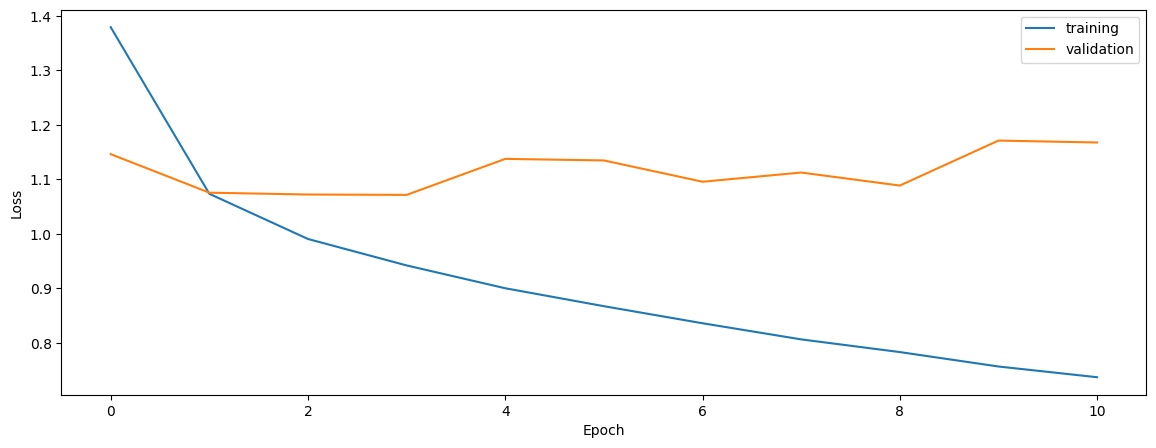

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6473760397098826
0.5782221801078511
0.5741084165477889


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5973123431439653
0.5849827882960413
0.537040268749182


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5976460556574765
0.5772912311585433
0.5398900890657571


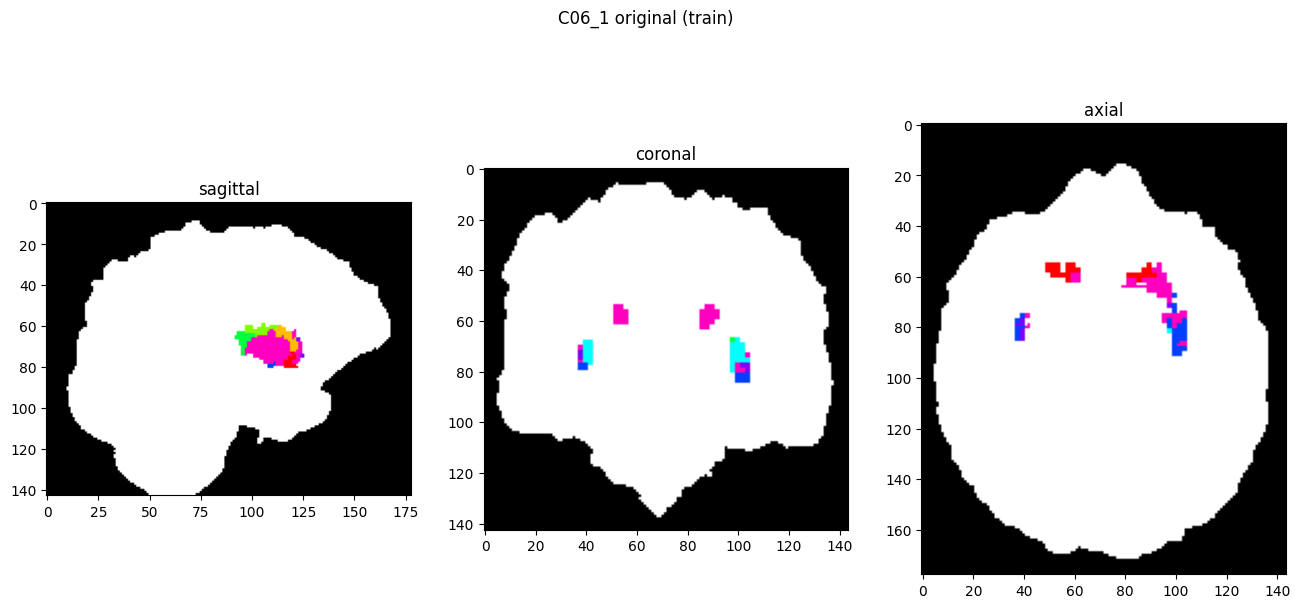

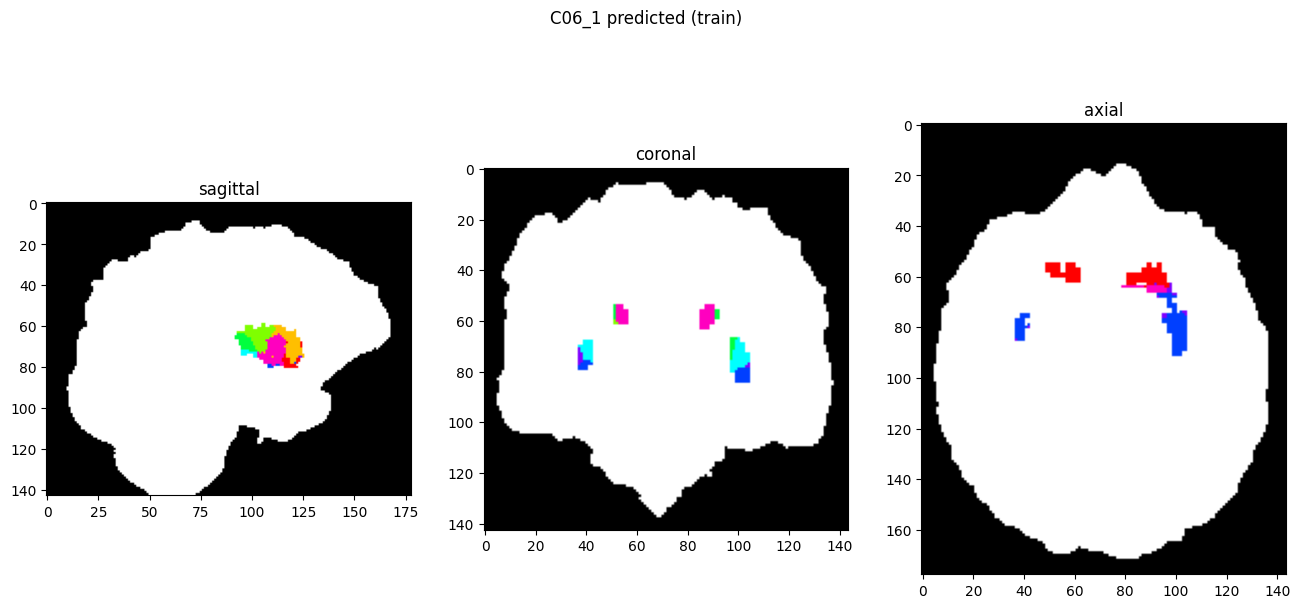

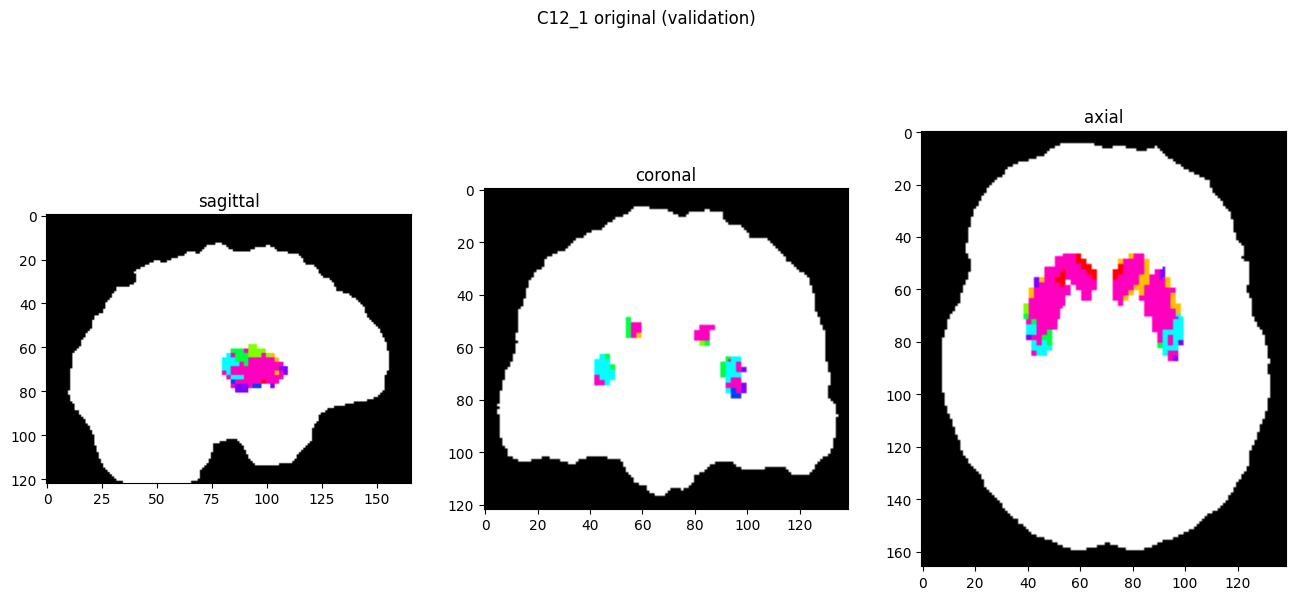

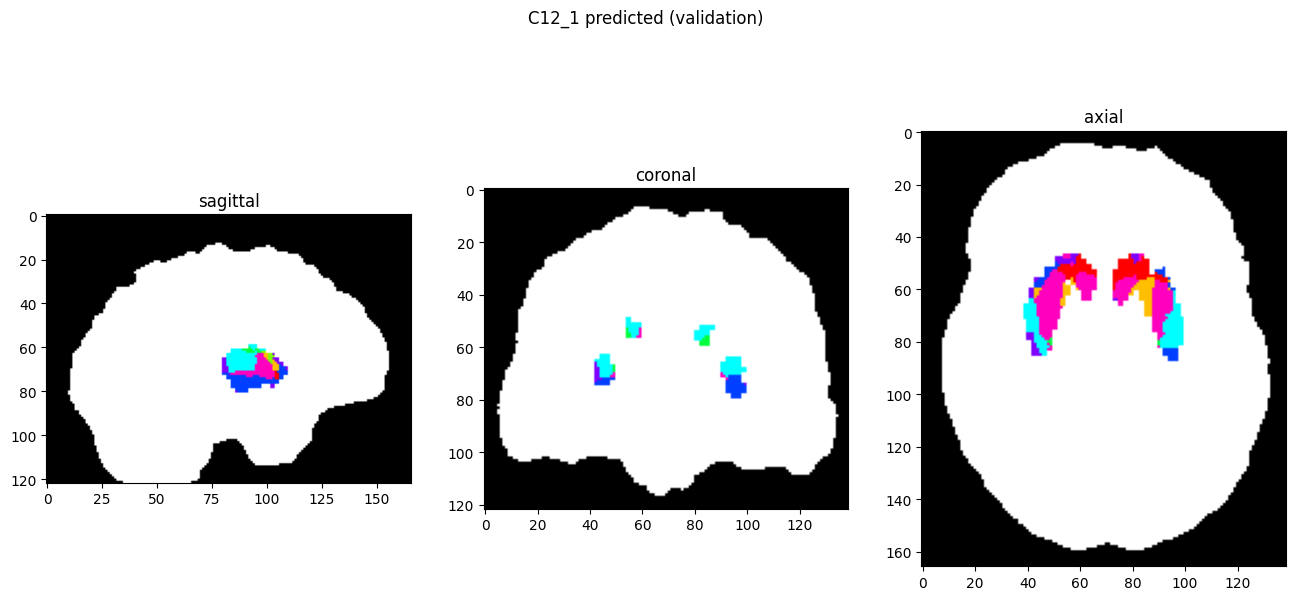

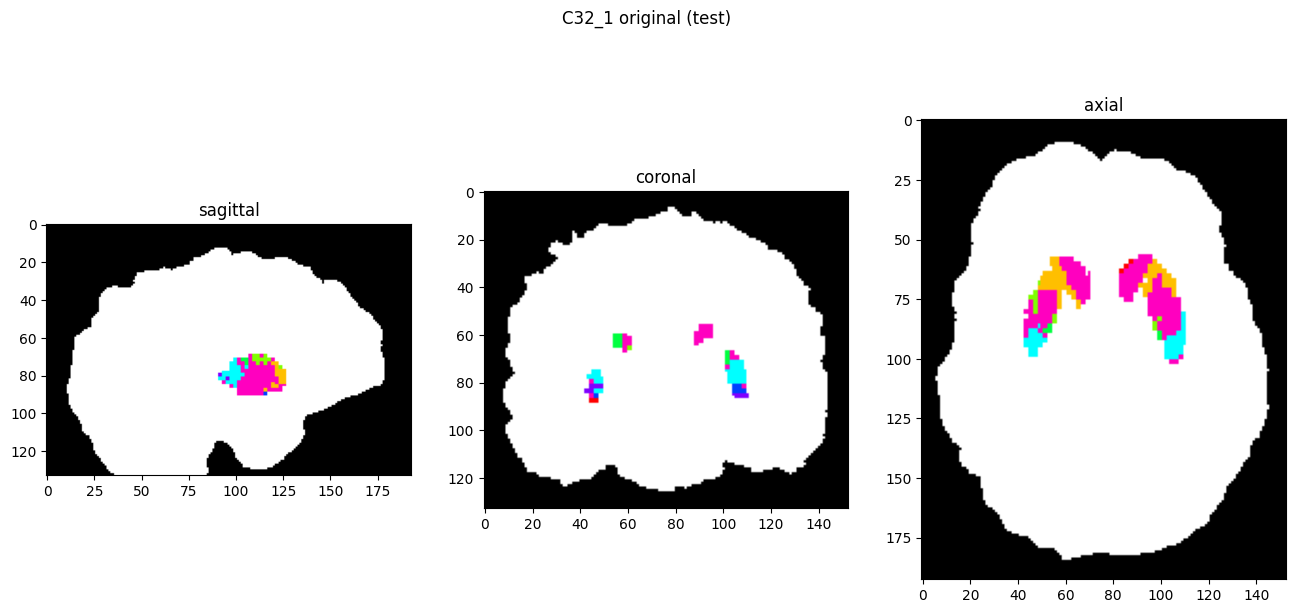

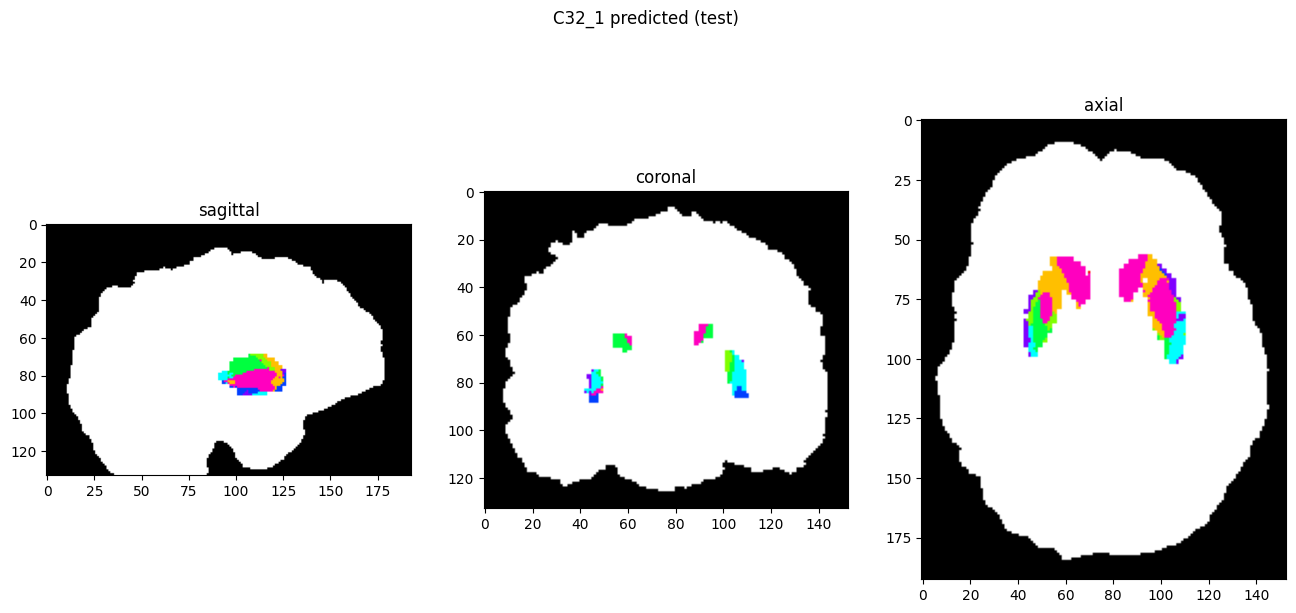

In [10]:
showResults(model, gen, threshold=0)